# Physics Informed Neural Network
Physics Informed Neural Networks (PINNs) are a class of deep learning models that incorporate physical laws, typically expressed as partial differential equations (PDEs), into the training process. By embedding these equations into the loss function, PINNs enable neural networks to learn solutions that are consistent with known physics, even when data is scarce or noisy. This approach is particularly useful for solving forward and inverse problems in science, where traditional numerical methods may be computationally expensive or limited by incomplete information.

To solve a PDE you need (i) a domain (D) definition, (ii) an initial (or constrined) condition (IC), and (iii) boundary condition (BC). These requirements define a boundary value problem (BVP).
Since the aim in a PINN experiment is to find an approximate solution to a BVP, the inputs to these networks are spatiotemporal coordinates and the outputs are the solution values at those points and times.\
During training, we can distinguish a supervised component — the data-driven part (e.g., experimental data embedded in the IC) — and an unsupervised component — the equation-driven part provided by the PDE and the BC.

In this exercise we implement a PINN for a simple BVP that admits an analytic solution. This will provide the fundamental tools used subsequently for more complex problems.

**NB:** No specific Python library is suggested. Students should write the code using whichever libraries they prefer.

## BVP to solve
For simplicity (and to not spoil the fun of trying to do better), we choose the 1D heat equation:

$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}, \qquad x \in [0,L],\ t \in [0,T]$

IC: $u(x,0) = \sin\!\left(\frac{\pi x}{L}\right)$

BC: $u(0,t) = u(L,t) = 0 \quad \forall t > 0$

The analytical solution is:

$u(x,t) = \sin\!\left(\frac{\pi x}{L}\right) \exp\!\left(-\frac{\pi^2 D}{L^2} t\right)$

## ✅ Solution Validation

This is the complete solution notebook. You can run the test suite at any point to validate the implementation:

- After each major section (Geometry, PINN, Loss Functions)
- Or run all tests comprehensively before training

The test suite is in `test_pinn.py` and will validate all implementations.

---

## 1. Domain definition

To solve this equation using a PINN model, you need to define the computational domain and sample points from it.

**Task 1.1:** Create a Python `Class` called `Geometry` with the following specifications:

**Initialization:**
- Input: geometric and topological information of the domain (spatial domain `[0, L]`, temporal domain `[t_start, t_end]`)
- Store these parameters for later use

**Required Methods:**

1. **Method `sample_interior(N1)`** - Sample interior domain points
   - Input: `N1` (integer) - number of points to sample
   - Output: Array of shape `(N1, 2)` containing random `(x, t)` pairs where `x ∈ (0, L)` and `t ∈ (t_start, t_end)`
   - Note: Boundary points should be excluded (i.e., `x ≠ 0` and `x ≠ L`)

2. **Method `sample_boundary(N2)`** - Sample boundary points
   - Input: `N2` (integer) - number of points to sample
   - Output: Array of shape `(N2, 2)` containing random `(x, t)` pairs where `x ∈ {0, L}` and `t ∈ (t_start, t_end)`
   - Note: These points should be at the spatial boundaries only

3. **Method `sample_initial(N3)`** - Sample initial condition points
   - Input: `N3` (integer) - number of points to sample
   - Output: Array of shape `(N3, 2)` containing random `(x, 0)` pairs where `x ∈ [0, L]` and `t = 0`
   - Note: These points are for enforcing the initial condition

4. **Method `sample_at_time(N4, t1)`** (Optional but recommended)
   - Input: `N4` (integer) - number of points, `t1` (float) - specific time
   - Output: Array of shape `(N4, 2)` containing random `(x, t1)` pairs
   - Note: Useful for future exercises and visualization

**⚠️ Important:** Each call to these methods should return a *different* set of random points. Make sure to handle randomness appropriately in your implementation.

In [1]:
# inital imports
import numpy as np
import matplotlib.pyplot as plt



In [2]:
class Geometry():
    def __init__(self,L = 10, N = 100 ,t_start = 0.0 ,t_end = 1.0, Nt=100 ,resample=True,seed=500):
        '''
        Initialize the geometry.
        
        Parameters:
        -----------        
        L : float
            Length of the spatial domain
        N : int
            Number of grid points for visualization
        t_start : float
            Start time
        t_end : float
            End time
        Nt : int
            Number of time points for visualization  
        resample  : resample data at each call?
        seed      : random seed for replication

        '''

        self.L=L
        self.t_start=t_start
        self.t_end=t_end
        self.resample=resample
        self.seed=seed
        self.Nt = Nt
        self.dx = L / N
        self.dt = (t_end - t_start) / Nt
        # Grid points for visualization
        self.x = np.linspace(0, L, N)
        self.t = np.linspace(t_start, t_end, Nt)   

    def resample_seed(self):
        """
        Function to ensure randomness at each call
        """
        if self.resample:
            #print('resampling seed')
            self.seed=np.random.randint(1000000)             

    def sample_interior(self,N1):
        """
        Sample N1 random points in the interior of the domain (boundaries excluded).
        
        Parameters:
        -----------
        N1 : int
            Number of points to sample
            
        Returns:
        --------
        points : array of shape (N1, 2)
            Array containing (x, t) pairs where x ∈ (0, L) and t ∈ (t_start, t_end)
        """        
        self.resample_seed()
        np.random.seed(self.seed)

        x=np.random.uniform(0,self.L,N1)
        t=np.random.uniform(self.t_start,self.t_end,N1)
        return np.stack([x,t],-1)

    def sample_boundary(self,N2):
        """
        Sample N2 random points on the spatial boundaries x=0 and x=L.
        
        Parameters:
        -----------
        N2 : int
            Number of points to sample (should be even for equal distribution)
            
        Returns:
        --------
        points : array of shape (N2, 2)
            Array containing (x, t) pairs where x ∈ {0, L} and t ∈ (t_start, t_end)
        """        
        self.resample_seed()
        np.random.seed(self.seed)

        x=np.random.choice([0,self.L],N2,True)
        t=np.random.uniform(self.t_start,self.t_end,N2)
        return np.stack([x,t],-1)

    def sample_initial(self,N3):
        """
        Sample N3 random points at the initial time t=0.
        
        Parameters:
        -----------
        N3 : int
            Number of points to sample
            
        Returns:
        --------
        points : array of shape (N3, 2)
            Array containing (x, 0) pairs where x ∈ [0, L] and t = 0
        """        
        self.resample_seed()
        np.random.seed(self.seed)

        x=np.random.uniform(0,self.L,N3)
        t=np.zeros_like(x)
        return np.stack([x,t],-1)

    def sample_at_time(self,n_point, t1):
        """
        Sample N4 random points at a specific time t1.
        (Optional method - useful for inverse problems and visualization)
        
        Parameters:
        -----------
        N4 : int
            Number of points to sample
        t1 : float
            Specific time value
            
        Returns:
        --------
        points : array of shape (N4, 2)
            Array containing (x, t1) pairs where x ∈ [0, L]
        """        
        self.resample_seed()
        np.random.seed(self.seed)

        x=np.random.uniform(0,self.L,n_point)
        t=np.ones_like(x)*t1
        return np.stack([x,t],-1)



In [3]:
from test_pinn_keras import test_geometry

test_geometry(Geometry)

2025-11-20 16:24:20.305130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 16:24:20.446652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-20 16:24:20.954983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anaconda3/envs/DL_tf/lib:/home/anaconda3/envs/DL_tf/lib:
2025-11-20 16:24:20.955072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnv

Testing Geometry Class


TEST SUMMARY

✅ PASSED (5 tests):
   • Geometry initialization
   • Geometry.sample_interior()
   • Geometry.sample_boundary()
   • Geometry.sample_initial()
   • Geometry.sample_at_time() [OPTIONAL]

Total: 5/5 tests passed



## 2. Domain Visualization & Validation

**Task 2.1:** Verify your `Geometry` class implementation

Create a visualization that displays sampled points in the `(x, t)` plane with:
- Interior points (from `sample_interior`) in one color
- Boundary points (from `sample_boundary`) in another color  
- Initial condition points (from `sample_initial`) in a third color

**Questions to consider:**
1. Does your visualization show that points are sampled from the correct regions?
2. Are the boundary points only at `x = 0` and `x = L`?
3. Are the initial condition points only at `t = 0`?
4. What would be a good choice of `(N1, N2, N3)` to adequately sample the domain? Consider:
   - The relative importance of each constraint (PDE, BC, IC)
   - The domain size and dimensionality
   - Computational cost vs. accuracy trade-offs

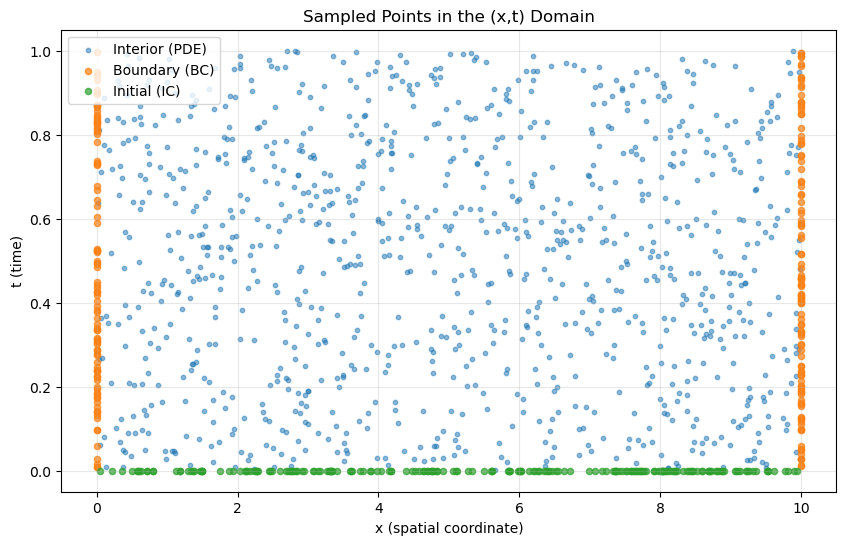

In [4]:
# Define domain parameters
L = 10.0          # Spatial domain length
t_start = 0.0     # Start time
t_end = 1.0       # End time

# Create geometry object
geo = Geometry(L=L, t_start=t_start, t_end=t_end, resample=True)

# Sample points for visualization
N1 = 1000  # Interior points
N2 = 200   # Boundary points
N3 = 200   # Initial condition points

# Generate different types of points
points_interior = geo.sample_interior(N1)
points_boundary = geo.sample_boundary(N2)
points_initial = geo.sample_initial(N3)

# Visualize the sampled points
plt.figure(figsize=(10, 6))
plt.scatter(points_interior[:, 0], points_interior[:, 1], 
            label='Interior (PDE)', alpha=0.5, s=10)
plt.scatter(points_boundary[:, 0], points_boundary[:, 1], 
            label='Boundary (BC)', alpha=0.7, s=20)
plt.scatter(points_initial[:, 0], points_initial[:, 1], 
            label='Initial (IC)', alpha=0.7, s=20)
plt.xlim(-0.5, L+0.5)
plt.ylim(-0.05, t_end+0.05)
plt.xlabel('x (spatial coordinate)')
plt.ylabel('t (time)')
plt.title('Sampled Points in the (x,t) Domain')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Neural Network Architecture

**Task 3.1:** Define a Neural Network that will approximate the solution `u(x, t)`

**Network Requirements:**

1. **Architecture constraints:**
   - Input layer: dimension = 2 (representing `x` and `t`)
   - Hidden layers: number and width are yours to choose (see tips below)
   - Output layer: dimension = 1 (representing `u(x, t)`)
   - Must satisfy the universal approximation theorem

2. **Activation function:**
   - Must be continuously differentiable (the network needs to compute derivatives)
   - Common choices: `tanh`, `sigmoid`, `softplus`, `GELU`
   - Avoid: `ReLU` (non-differentiable at 0, though often works in practice)

3. **Input/Output specification:**
   - Input: Array of shape `(N, 2)` containing `(x, t)` coordinates
   - Output: Array of shape `(N, 1)` containing predicted `u(x, t)` values

**💡 Tips:**

1. **Model capacity:** Start simple, then increase complexity if needed
   - For this 1D heat equation, try starting with 2-3 hidden layers of 20-50 neurons each
   - If the model doesn't learn well, consider increasing depth or width
   - If training is slow or unstable, try reducing complexity

2. **Parameter initialization:** This is critical for PINN training!
   - **Problem:** Random normal initialization often leads to trivial solutions (e.g., `u ≈ 0` everywhere)
   - **Solutions:**
     - Use **Glorot/Xavier uniform initialization** (strongly recommended)
     - Alternatively, use careful loss weighting (covered later)
   - Most deep learning libraries provide Glorot initialization (e.g., `glorot_uniform` in Keras/JAX)

3. **Implementation tips:**
   - Your network should be a callable function/class that takes `(x, t)` coordinates and returns `u` predictions
   - Ensure you can access intermediate gradients (needed for computing derivatives in the loss function)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import GlorotUniform


def pinn_model(input_shape=(2,),
               output_shape=1,
               hidden_layers=[None],
               activation='tanh',
               initializer_seed=100,
               name='PINN_model'):
    """
    Here we create a NN

    Args:
    --------------------
    input_shape : tuple
        Shape of the input layer (default is (2,) for 1D space + time)
    output_shape : int
        Shape of the output layer (default is 1)
    hidden_layers : list of int
        List containing the number of units in each hidden layer,
        e.g, [2,20,20,20,1]
    activation : str
        Activation function to use in hidden layers (default is 'tanh')
    initializer_seed : int
        Seed for the GlorotUniform initializer (default is 100)
    name : str
        Model's name
    """


    initializer=GlorotUniform(initializer_seed) #100 is a seed for parameters inizialization
    inp=layers.Input(shape=input_shape)
    for units in hidden_layers:
        x=layers.Dense(units, activation=activation, kernel_initializer=initializer)(inp if 'x' not in locals() else x)
    out=layers.Dense(output_shape, kernel_initializer=initializer)(x)
    pinn=keras.Model(inp, out, name=name)
    return pinn

In [6]:
pinn=pinn_model((2,),1,hidden_layers=[10,20,200,20,10])
pinn.summary()

Model: "PINN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 200)               4200      
                                                                 
 dense_3 (Dense)             (None, 20)                4020      


2025-11-20 16:24:22.009385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 16:24:22.920968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9228 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0, compute capability: 8.6
2025-11-20 16:24:22.921579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22120 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6


                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 8,691
Trainable params: 8,691
Non-trainable params: 0
_________________________________________________________________


In [7]:
from test_pinn_keras import test_pinn

test_pinn(pinn_model,True)


Testing PINN Class


TEST SUMMARY

✅ PASSED (4 tests):
   • PINN initialization
   • PINN forward pass
   • PINN output variation
   • PINN parameter initialization (Glorot-like)

Total: 4/4 tests passed



2025-11-20 16:24:23.736602: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## 4. Neural Network Validation

**Task 4.1:** Test your network implementation

Before moving to training, verify that:
1. Your network accepts inputs of shape `(N, 2)` and produces outputs of shape `(N, 1)`
2. You can generate sample points using your `Geometry` class and pass them through the network
3. The output values are reasonable (not `NaN` or extremely large)

**Suggestion:** Create a few test points using your `Geometry` class and check that forward propagation works correctly.

In [8]:
# Test forward pass with some example points
x_test = np.array([[1.0, 0.5],   # (x=1.0, t=0.5)
                     [2.0, 0.5]])   # (x=2.0, t=0.5)
u_test = pinn(x_test)

print("Test inputs (x, t):")
print(x_test)
print("\nTest outputs u(x, t):")
print(u_test)
print("\nNetwork initialized successfully! ✓")

Test inputs (x, t):
[[1.  0.5]
 [2.  0.5]]

Test outputs u(x, t):
tf.Tensor(
[[-0.62445855]
 [-0.8008533 ]], shape=(2, 1), dtype=float32)

Network initialized successfully! ✓


## 5. Loss Functions

**Task 5.1:** Implement the physics-informed loss function

The loss function is what makes this network "physics-informed". It enforces the PDE, boundary conditions, and initial conditions. We split it into three components:

---

### 5.1 PDE Residual Loss: $\mathcal{L}_{PDE}$

This enforces that the network satisfies the heat equation at interior points.

**Mathematical definition:**

$$\mathcal{L}_{PDE}= \frac{1}{N_1} \sum_{i=1}^{N_1} \left(\frac{\partial}{\partial t}NN(x_i,t_i)-D\frac{\partial^2}{\partial x^2}NN(x_i,t_i)\right)^2$$

**Implementation requirements:**
- **Input:** 
  - Interior points `(x, t)` from `sample_interior(N1)` - shape `(N1, 2)`
  - Network prediction function `NN(x, t)`
  - Diffusion coefficient `D`
- **Steps:**
  1. For each point `(xi, ti)`, compute `u = NN(xi, ti)`
  2. Compute time derivative: `∂u/∂t` using automatic differentiation
  3. Compute second spatial derivative: `∂²u/∂x²` using automatic differentiation
  4. Calculate residual: `r = ∂u/∂t - D·∂²u/∂x²`
  5. Return mean squared residual: `mean(r²)`
- **Output:** Scalar value representing PDE residual loss

---

### 5.2 Boundary Condition Loss: $\mathcal{L}_{BC}$

This enforces Dirichlet boundary conditions: `u(0, t) = u(L, t) = 0` for all `t > 0`.

**Mathematical definition:**

$$\mathcal{L}_{BC}= \frac{1}{N_2} \sum_{i=1}^{N_2} (NN(x_i, t_i))^2 \quad \text{where } x_i \in \{0, L\}$$

**Implementation requirements:**
- **Input:**
  - Boundary points from `sample_boundary(N2)` - shape `(N2, 2)`, where `x ∈ {0, L}`
  - Network prediction function `NN(x, t)`
- **Steps:**
  1. Evaluate network at boundary points: `u_boundary = NN(x_boundary, t_boundary)`
  2. Return mean squared predictions: `mean(u_boundary²)`
- **Output:** Scalar value representing boundary condition loss
- **Note:** Since the boundary condition is `u = 0`, we simply penalize any non-zero predictions

---

### 5.3 Initial Condition Loss: $\mathcal{L}_{IC}$

This is the *supervised* component, enforcing the initial condition: `u(x, 0) = sin(πx/L)`.

**Mathematical definition:**

$$\mathcal{L}_{IC}=\frac{1}{N_3} \sum_{i=1}^{N_3} (NN(x_i,0)-\sin(\pi x_i/L))^2$$

**Implementation requirements:**
- **Input:**
  - Initial condition points from `sample_initial(N3)` - shape `(N3, 2)`, where `t = 0`
  - Network prediction function `NN(x, t)`
  - Domain length `L`
- **Steps:**
  1. Evaluate network at initial points: `u_pred = NN(x_initial, 0)`
  2. Compute exact initial condition: `u_exact = sin(π·x_initial/L)`
  3. Return mean squared error: `mean((u_pred - u_exact)²)`
- **Output:** Scalar value representing initial condition loss

---

### 5.4 Total Loss

$$\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{IC}$$

Optionally, you can use weighted losses: $\mathcal{L}_{total} = w_1\mathcal{L}_{PDE} + w_2\mathcal{L}_{BC} + w_3\mathcal{L}_{IC}$

---

**💡 Implementation Tips:**

1. **Automatic differentiation:** Use your framework's built-in tools
   - TensorFlow: `tf.GradientTape` (set `persistent=True` to compute multiple derivatives)
   - PyTorch: `torch.autograd.grad`
   - JAX: `jax.grad` or `jax.jacfwd`/`jax.jacrev`

2. **Computing higher-order derivatives:**
   - For `∂²u/∂x²`, you need to differentiate twice with respect to `x`
   - Ensure your automatic differentiation context can handle multiple derivative operations

3. **Debugging:** Test each loss component separately with known simple functions before combining them

In [9]:
import tensorflow as tf

@tf.function
def loss_pde(net, x,t ,D):
    """
    Compute the PDE residual loss: L_PDE.
    
    Enforces the heat equation: ∂u/∂t = D * ∂²u/∂x²
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x : array of spatial internal points
        tensorflow.tensor      
    t : array of time internal points
    tensorflow.tensor
    D : Diffusion coefficient
        tensorflow.tensor
        
    Returns:
    --------
    loss : Mean squared PDE residual
            tensorflow.tensor
    """
    with tf.GradientTape(persistent=True) as tape: #“Persistent” indicates a persistent graph. 
        #By default, it is set to False because it is computationally expensive; 
        #however, in our case, since we need to compute two derivatives, it must be enabled.
        tape.watch([x,t]) #Here we specify which variables are the independent ones (normally, for it, these are the network parameters)
        u=net(tf.stack([x,t],-1), training=True)# this is the network forward projection
        u_x=tape.gradient(u,x) #calculation of the first derivative of u with respect to x using the tape.gradient function
    #here we are outside the computational graph

    u_t=tape.gradient(u,t) #first derivative with respect to time
    u_xx=tape.gradient(u_x,x)#second derivative with respect to space
    pde_loss=tf.reduce_mean(tf.square(u_t-D*u_xx))
    return pde_loss


@tf.function
def loss_bc(net,x,t):
    """
    Compute the boundary condition loss: L_BC.
    
    Enforces Dirichlet BC: u(0, t) = u(L, t) = 0
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x : array of spatial points, where x ∈ {0, L} 
    t : array of time internal points
        
    Returns:
    --------
    loss : float
        Mean squared boundary predictions (should be zero)
    """    
    u=net(tf.stack([x,t],-1),training=True) # this is the network forward projection
    BC_loss=tf.reduce_mean(tf.square(u)) # Since BC is u=0, we penalize any non-zero predictions
    return BC_loss


@tf.function
def loss_ic(net,xic,tic,true_ic):
    """
    Compute the initial condition loss: L_IC.
    
    Enforces IC: u(x, 0) = sin(πx/L)
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    xic : array of spatial points
    tic : array of time points, with t = 0
    true_ic : Exact initial values: u(xic, xic) = sin(πx/L)
        
    Returns:
    --------
    loss : float
        Mean squared error between predictions and exact IC
    """    
    uic=net(tf.stack([xic,tic],-1),training=True)
    IC_loss=tf.reduce_mean(tf.square(uic-true_ic))
    return IC_loss


def PDE(network, point_int, point_BC, point_IC, D,L):
    """
    Compute the total physics-informed loss.
    
    L_total = L_PDE + L_BC + L_IC
    
    Parameters:
    -----------
    network : Pinn model
        keras model
    points_int : array
        Interior domain points
    points_BC : array
        Boundary points
    points_IC : array
        Initial condition points
    D : float
        Diffusion coefficient
    L : float
        Domain length
        
    Returns:
    --------
    total : float
        Total loss value
    components : tuple
        Individual loss components (l_pde, l_bc, l_ic) for monitoring
    """

    # Exact initial condition: u(x, 0) = sin(πx/L)
    def initial(x,L=L):
        return np.sin(np.pi*x/L)
    
    #Since we are running loss computation under @tf.funtion its better working only with tensors
    x=tf.constant(point_int[:,0], tf.float32)
    t=tf.constant(point_int[:,1], tf.float32)
    D=tf.constant(D, tf.float32)
    pde_loss=loss_pde(network,x,t,D)

    xbc=tf.constant(point_BC[:,0], tf.float32)
    tbc=tf.constant(point_BC[:,1], tf.float32)
    BC_loss=loss_bc(network,xbc,tbc)

    xic=tf.constant(point_IC[:,0], tf.float32)
    tic=tf.constant(point_IC[:,1], tf.float32)
    true_ic=tf.cast(np.expand_dims(initial(xic),-1),tf.float32)
    IC_loss=loss_ic(network,xic,tic,true_ic)

    total_loss=pde_loss+BC_loss+IC_loss
    return total_loss,(pde_loss,BC_loss, IC_loss)

## 6. Loss Function Validation

**Task 6.1:** Test your loss implementations

Before training, verify that each loss component works correctly:

1. **Test with simple inputs:**
   - Sample a small number of points (e.g., `N1=10`, `N2=10`, `N3=10`)
   - Compute each loss term separately
   - Check that all values are finite (not `NaN` or `Inf`)

2. **Sanity checks:**
   - For a randomly initialized network, all losses should be non-zero
   - `L_BC` should be relatively small if the network happens to predict values close to zero at boundaries
   - `L_IC` depends on how far the random predictions are from `sin(πx/L)`

3. **Test derivatives:**
   - Ensure automatic differentiation is computing gradients correctly
   - Try evaluating `∂u/∂t` and `∂²u/∂x²` at a single point and verify they are computable

**Debugging tip:** If you encounter errors, test each loss function independently before combining them.

In [10]:
# Sample test points
N1_test = 100  # Small number for testing
N2_test = 20
N3_test = 20

points_interior = geo.sample_interior( N1_test)
points_boundary = geo.sample_boundary( N2_test)
points_initial = geo.sample_initial( N3_test)

# Compute each loss component
D_test = 3
l_t, (l_pde , l_bc, l_ic) = PDE(pinn, points_interior, points_boundary, points_initial, D_test,L)

print("Loss components for untrained network:")
print(f"  L_PDE (PDE residual):        {l_pde:.6f}")
print(f"  L_BC  (Boundary conditions): {l_bc:.6f}")
print(f"  L_IC  (Initial condition):   {l_ic:.6f}")
print(f"  L_total:                     {l_pde + l_bc + l_ic:.6f}")
print("\nAll losses computed successfully! ✓")

Loss components for untrained network:
  L_PDE (PDE residual):        0.276640
  L_BC  (Boundary conditions): 0.335532
  L_IC  (Initial condition):   2.433146
  L_total:                     3.045317

All losses computed successfully! ✓


In [11]:
from test_pinn_keras import test_loss_functions

test_loss_functions(loss_pde, loss_bc, loss_ic, PDE,pinn_model,Geometry, True)

Testing Loss Functions


TEST SUMMARY

✅ PASSED (5 tests):
   • loss_pde()
   • loss_bc()
   • loss_ic()
   • total_loss()
   • total_loss consistency

Total: 5/5 tests passed



## 7. Training Loop

**Task 7.1:** Implement the training procedure

Now that all components are ready, implement the optimization loop to train your PINN.

---

### 7.1 Core Training Operations

Your training loop should perform these steps at each iteration:

1. **Sample points:** Generate new random sets of:
   - Interior points `(x, t)` using `sample_interior(N1)`
   - Boundary points `(x, t)` using `sample_boundary(N2)`
   - Initial condition points `(x, 0)` using `sample_initial(N3)`

2. **Forward pass & loss computation:**
   - Evaluate the network at all sampled points
   - Compute `L_PDE`, `L_BC`, `L_IC`, and `L_total`

3. **Backward pass & optimization:**
   - Compute gradients of `L_total` with respect to network parameters
   - Update parameters using an optimizer (Adam recommended)

4. **Monitoring:**
   - Print/log loss values periodically
   - Track the best model (lowest total loss)
   - Save checkpoints when a new minimum is reached

---

### 7.2 Implementation Suggestions

For clean, readable code, consider organizing as follows:

**Option A: Unified PDE function**
- Create a function `compute_pde_loss(model, interior_points, boundary_points, initial_points, D, L)` that:
  - Takes all inputs and hyperparameters
  - Returns all loss components `(L_total, L_PDE, L_BC, L_IC)`
- Your training loop then only needs:
  1. Sample points from `Geometry` class
  2. Call `compute_pde_loss()` within gradient computation context
  3. Apply optimizer step
  4. Monitor and save

**Option B: Separate components**
- Keep loss functions separate as implemented in Task 5
- Call them individually in the training loop

---

### 7.3 Training Hyperparameters

**Optimizer:**
- **Recommended:** Adam with learning rate `1e-3` to `1e-4`
- **Alternative:** Try L-BFGS for fine-tuning after initial Adam training (see tips below)

**Number of epochs:**
- Start with 5,000-10,000 epochs
- Monitor loss curves to determine if more training is needed

**Sampling sizes:**
- Typical values: `N1=1000`, `N2=200`, `N3=200`
- Adjust based on computational resources and convergence behavior

---

### 7.4 Tips & Best Practices

**1. Loss weighting (if needed):**
   - If one loss component dominates, consider weighting: `L_total = w1·L_PDE + w2·L_BC + w3·L_IC`
   - Start with equal weights (1, 1, 1) and adjust if necessary

**2. Advanced optimization - L-BFGS:**
   - Some PINN literature recommends [L-BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) (second-order optimizer)
   - **Strategy:** Train with Adam first, then fine-tune with L-BFGS
   - Not required but can improve convergence

**3. Monitoring:**
   - Print each loss component separately to diagnose issues
   - If one component doesn't decrease, check its implementation

**4. Stopping criterion:**
   - **Key question:** *Without a validation set, how do you decide when to stop training?*
   - Consider:
     - Has the total loss plateaued?
     - Are all three loss components sufficiently small?
     - Does the solution look physically reasonable?
     - Compare with analytical solution (if available, as in this exercise)

**5. Checkpointing:**
   - Save the model parameters whenever `L_total` reaches a new minimum
   - This protects against divergence in later epochs

---

### 7.5 Expected Behavior

During training, you should observe:
- All loss components decreasing over time
- `L_IC` typically decreases fastest (it's supervised)
- `L_PDE` often decreases more slowly
- Total loss should eventually plateau at a low value (e.g., < 0.01 or lower)

In [12]:
#training loop

def train_pinn(pinn, geo, D, L, n_epochs=5000, N1=1000, N2=200, N3=200, learning_rate=1e-3, checkpoint_dir = None, summary_function=None, fine_tune : bool = False):
    """
    Train the Physics-Informed Neural Network.
    
    Parameters:
    -----------
    pinn : Pinn
        PINN object to train
    geo : Geometry
        Geometry object for sampling points
    D : float
        Diffusion coefficient
    L : float
        Domain length
    n_epochs : int
        Number of training iterations
    N1, N2, N3 : int
        Number of interior, boundary, and initial condition points per epoch
    learning_rate : float
        Adam optimizer learning rate
    checkpoint_dir : str
        Directory to save model checkpoints (optional). If None, checkpoints are savede in the folder './training_PINN'.
    summary_function : function
        Function to log training summaries (optional)
    fine_tune : bool
        If True, continue training from existing weights
        
    Returns:
    --------
    trained_pinn : Pinn
        Trained PINN model (at the last epoch)
    loss_history : list
        Total loss at each epoch
    loss_components : dict
        History of individual loss components
    """
    # Loss history for monitoring
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'ic': []}

    # Initialize Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if fine_tune:
        print("Computing initial loss before fine-tuning...")
        initial_loss= PDE(pinn,
                  geo.sample_interior(N1),
                  geo.sample_boundary(N2),
                  geo.sample_initial(N3),
                  D,L)
        best_loss= initial_loss[0].numpy()
        loss_history.append(best_loss)
        print(f"Initial total loss: {best_loss:.6f}")
        loss_components['pde'].append(initial_loss[1][1].numpy())
        loss_components['bc'].append(initial_loss[1][2].numpy())
        loss_components['ic'].append(initial_loss[1][3].numpy())
    else:
        best_loss = np.inf

    print(f"Starting training for {n_epochs} epochs...")
    print(f"Sampling: N1={N1} (interior), N2={N2} (boundary), N3={N3} (initial)\n")
    
    # Setup checkpointing
    print('Setting up checkpointing...')
    if checkpoint_dir is None:
        checkpoint_dir = './training_PINN'
    print(f'Checkpoint directory: {checkpoint_dir}')
    checkpoint=tf.train.Checkpoint(
                generator_optimizer=optimizer,
                generator=pinn
                    )
    manager=tf.train.CheckpointManager(checkpoint,checkpoint_dir, max_to_keep=1)

    
    for epoch in range(n_epochs):
        # Sample points
        points_interior = geo.sample_interior(N1)
        points_boundary = geo.sample_boundary(N2)
        points_initial = geo.sample_initial(N3)

        with tf.GradientTape() as tape:
            total_loss, (pde_loss, bc_loss, ic_loss) = PDE(
                pinn, points_interior, points_boundary, points_initial, D,L)
        # Record losses
        loss_history.append(total_loss.numpy())
        loss_components['pde'].append(pde_loss.numpy())
        loss_components['bc'].append(bc_loss.numpy())
        loss_components['ic'].append(ic_loss.numpy())
        
        # Compute gradients and update weights
        gradients = tape.gradient(total_loss, pinn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

        if total_loss<best_loss:
            #print('Find new best! Model checkpoint saving')
            manager.save()

        # Log summaries if function provided
        if summary_function:
            summary_function(epoch, total_loss, pde_loss, bc_loss, ic_loss)

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{n_epochs} - Total Loss: {total_loss:.6f} "
                    f"(PDE: {pde_loss:.6f}, BC: {bc_loss:.6f}, IC: {ic_loss:.6f})")
    
    print("Training completed!")
    return pinn, loss_history, loss_components



In [13]:
from test_pinn_keras import test_train_function

test_train_function(train_pinn,pinn_model,Geometry)

Testing Training Function (Basic Checks)

Running training for 10 epochs (this may take a moment)...

Starting training for 10 epochs...
Sampling: N1=50 (interior), N2=20 (boundary), N3=20 (initial)

Setting up checkpointing...
Checkpoint directory: ./training_PINN
Epoch 1/10 - Total Loss: 7.049221 (PDE: 0.215200, BC: 2.227294, IC: 4.606726)
Training completed!

TEST SUMMARY

✅ PASSED (2 tests):
   • train_pinn() basic functionality
   • Training reduces loss

Total: 2/2 tests passed



In [14]:
from test_pinn_keras import run_all_tests

run_all_tests(Geometry, pinn_model, loss_pde,loss_bc, loss_ic,PDE, train_pinn)


RUNNING COMPREHENSIVE TEST SUITE

Testing Geometry Class


TEST SUMMARY

✅ PASSED (5 tests):
   • Geometry initialization
   • Geometry.sample_interior()
   • Geometry.sample_boundary()
   • Geometry.sample_initial()
   • Geometry.sample_at_time() [OPTIONAL]

Total: 5/5 tests passed

Testing PINN Class


TEST SUMMARY

✅ PASSED (4 tests):
   • PINN initialization
   • PINN forward pass
   • PINN output variation
   • PINN parameter initialization (Glorot-like)

Total: 4/4 tests passed

Testing Loss Functions


TEST SUMMARY

✅ PASSED (5 tests):
   • loss_pde()
   • loss_bc()
   • loss_ic()
   • total_loss()
   • total_loss consistency

Total: 5/5 tests passed

Testing Training Function (Basic Checks)

Running training for 10 epochs (this may take a moment)...

Starting training for 10 epochs...
Sampling: N1=50 (interior), N2=20 (boundary), N3=20 (initial)

Setting up checkpointing...
Checkpoint directory: ./training_PINN
Epoch 1/10 - Total Loss: 8.141302 (PDE: 0.613576, BC: 2.694269, IC

True

In [15]:
#define a summary function

#A nice way to log the losses during training is to use tensorboard
# define folders for tensorboard logs
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(
log_dir + "total_loss/")
summary_writer_2 = tf.summary.create_file_writer(
log_dir + 'pde_loss/')
summary_writer_3 = tf.summary.create_file_writer(
log_dir + 'ic_loss/')
summary_writer_4 = tf.summary.create_file_writer(
log_dir + 'bc_loss/')

def summary_function(epoch, total_loss, pde_loss, bc_loss, ic_loss):
    with summary_writer.as_default():
        tf.summary.scalar('total_loss', total_loss, step=epoch+1)
    with summary_writer_2.as_default():
        tf.summary.scalar('pde_loss', pde_loss, step=epoch+1)
    with summary_writer_3.as_default():
        tf.summary.scalar('ic_loss', ic_loss, step=epoch+1)
    with summary_writer_4.as_default():
        tf.summary.scalar('bc_loss', bc_loss, step=epoch+1)

#we can monitor the losses during training using the command
# tensorboard --logdir=logs/
#this command loads the tensorboard extension
%load_ext tensorboard

In [16]:
#this command launches tensorboard platform
#here we will see the losses during training
#if it doesn't appear try run twice
#set on time series
#set Reload data
%tensorboard --logdir=$log_dir

TRAINING PHYSICS-INFORMED NEURAL NETWORK
Starting training for 1000 epochs...
Sampling: N1=1000 (interior), N2=200 (boundary), N3=200 (initial)

Setting up checkpointing...
Checkpoint directory: ./training_PINN
Epoch 1/1000 - Total Loss: 1.072806 (PDE: 0.065425, BC: 0.744415, IC: 0.262966)
Epoch 100/1000 - Total Loss: 0.078263 (PDE: 0.009060, BC: 0.022963, IC: 0.046240)
Epoch 200/1000 - Total Loss: 0.026496 (PDE: 0.007105, BC: 0.005372, IC: 0.014019)
Epoch 300/1000 - Total Loss: 0.011934 (PDE: 0.003958, BC: 0.001570, IC: 0.006406)
Epoch 400/1000 - Total Loss: 0.006781 (PDE: 0.002825, BC: 0.000264, IC: 0.003692)
Epoch 500/1000 - Total Loss: 0.003922 (PDE: 0.001948, BC: 0.000602, IC: 0.001373)
Epoch 600/1000 - Total Loss: 0.002301 (PDE: 0.001406, BC: 0.000158, IC: 0.000737)
Epoch 700/1000 - Total Loss: 0.001398 (PDE: 0.000941, BC: 0.000087, IC: 0.000370)
Epoch 800/1000 - Total Loss: 0.001079 (PDE: 0.000714, BC: 0.000080, IC: 0.000285)
Epoch 900/1000 - Total Loss: 0.000769 (PDE: 0.000534,

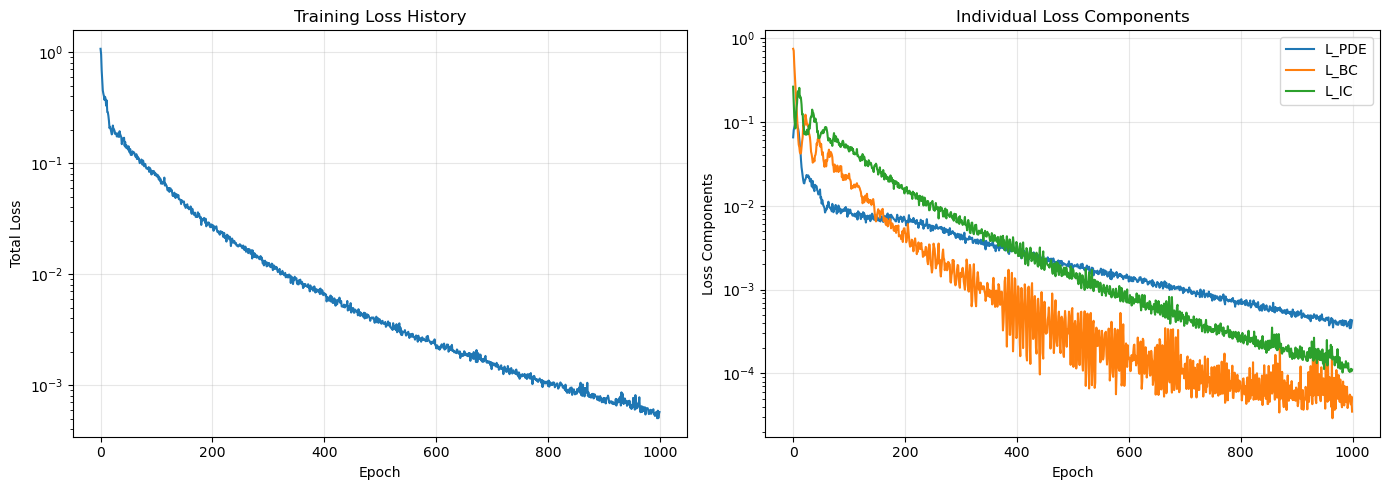

In [17]:


# Train the PINN

print("="*70)
print("TRAINING PHYSICS-INFORMED NEURAL NETWORK")
print("="*70)

# Define problem parameters
L = 10.0
D = 3

# Create a fresh PINN
pinn_layers = [20, 20, 20]

pinn = pinn_model(input_shape=(2,),
                  output_shape=1,
                  hidden_layers=pinn_layers,
                  activation='tanh',
                  initializer_seed=100)   


# Train
pinn, loss_history, loss_components = train_pinn(
    pinn, geo, D, L, 
    n_epochs=1000, 
    N1=1000, N2=200, N3=200,
    learning_rate=1e-3,
    summary_function=summary_function
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total loss
axes[0].plot(loss_history, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Loss History')
axes[0].grid(True, alpha=0.3)

# Individual components
axes[1].plot(loss_components['pde'], label='L_PDE', linewidth=1.5)
axes[1].plot(loss_components['bc'], label='L_BC', linewidth=1.5)
axes[1].plot(loss_components['ic'], label='L_IC', linewidth=1.5)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Performance Evaluation

**Task 8.1:** Evaluate and analyze your trained PINN

Now that your model is trained, assess its performance and understand its behavior.

---

### 8.1 Quantitative Metrics

**Primary metric - Mean Absolute Error (MAE):**

Since we have the analytical solution for this problem:

$$u_{exact}(x,t) = \sin\!\left(\frac{\pi x}{L}\right) \exp\!\left(-\frac{\pi^2 D}{L^2} t\right)$$

Compute:
- **Absolute Error:** `|u_pred(x,t) - u_exact(x,t)|`
- **Mean Absolute Error:** Average absolute error over the domain
- **Maximum Error:** Worst-case pointwise error
- **Relative Error:** `|u_pred - u_exact| / |u_exact|` (where `u_exact ≠ 0`)

**Questions to answer:**
1. What is the average error across the entire domain?
2. Where is the error largest? (boundaries? interior? early/late times?)
3. Is the error acceptable for your application?

---

### 8.2 Qualitative Assessment

**Visualization tasks:**

1. **Solution comparison:**
   - Plot `u_pred(x,t)` as a heatmap/contour plot
   - Plot `u_exact(x,t)` as a heatmap/contour plot
   - Visually compare: Does the PINN capture the correct behavior?

2. **Error visualization:**
   - Plot absolute error `|u_pred - u_exact|` as a heatmap
   - Identify regions of high/low error

3. **Time slices:**
   - Plot `u(x, t)` vs `x` at several fixed times (e.g., `t = 0, 0.25, 0.5, 0.75, 1.0`)
   - Compare PINN predictions with analytical solution
   - Does the solution decay correctly over time?

4. **Spatial profiles:**
   - Plot `u(x, t)` vs `t` at several fixed locations (e.g., `x = L/4, L/2, 3L/4`)
   - Verify exponential decay in time

---

### 8.3 Comparison with Classical Methods

**Task 8.2:** Compare PINN with numerical methods

To understand PINNs' strengths and limitations, compare with traditional PDE solvers:

**Suggested method - FTCS (Forward-Time Central-Space):**
- Simple explicit finite difference scheme for the heat equation
- Discretize in space and time: `u[n+1, i] = u[n, i] + D·dt/dx²·(u[n,i+1] - 2u[n,i] + u[n,i-1])`
- **Note:** Check stability condition: `D·dt/dx² ≤ 0.5`

**Comparison criteria:**

1. **Accuracy:**
   - Which method has lower error compared to the analytical solution?
   - How does error scale with grid resolution (for FTCS) vs network size (for PINN)?

2. **Computational cost:**
   - Training time for PINN vs solve time for FTCS
   - Memory requirements

3. **Flexibility:**
   - How easy is it to change domain size, boundary conditions, or initial conditions?
   - Which method generalizes better to new scenarios?

4. **Physical constraints:**
   - Does the PINN naturally satisfy physical properties (e.g., positivity, conservation)?
   - Compare with FTCS in this regard

---

### 8.4 Reflection Questions

1. **When would you prefer a PINN over classical methods?**
   - Consider: sparse data, inverse problems, complex geometries, parameter estimation

2. **What are the main challenges you encountered?**
   - Hyperparameter tuning? Training stability? Computational cost?

3. **How would this approach scale to higher dimensions (2D/3D)?**
   - Think about: computational complexity, sampling strategies, network architecture

4. **What happens if you reduce the number of training points?**
   - Try reducing `N1`, `N2`, or `N3` and observe the effect on accuracy


QUANTITATIVE PERFORMANCE METRICS
Mean Absolute Error (MAE):     5.226819e-03
Maximum Absolute Error:        2.441505e-02
Mean Relative Error:           9.774517e+05



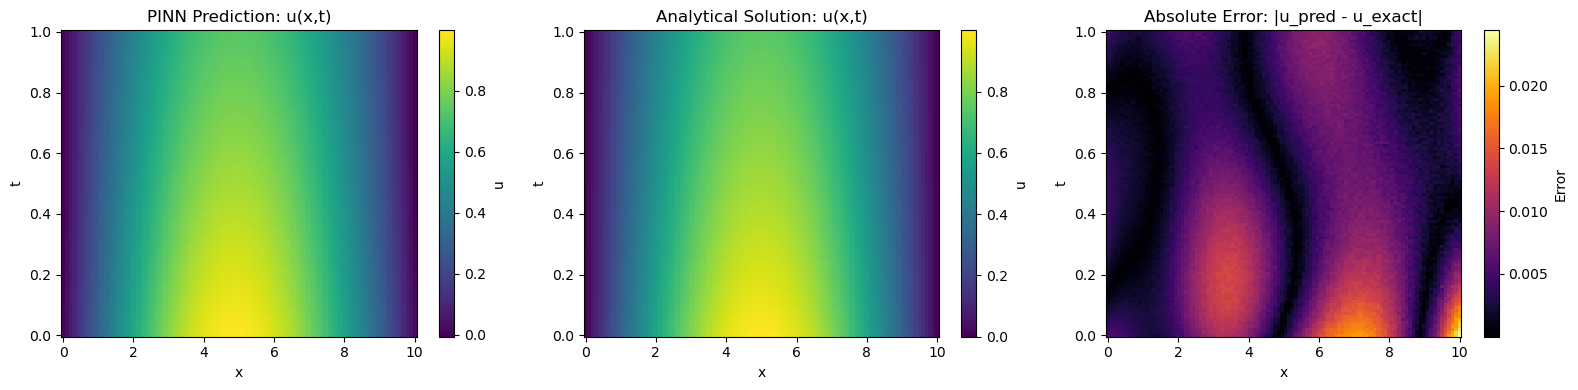

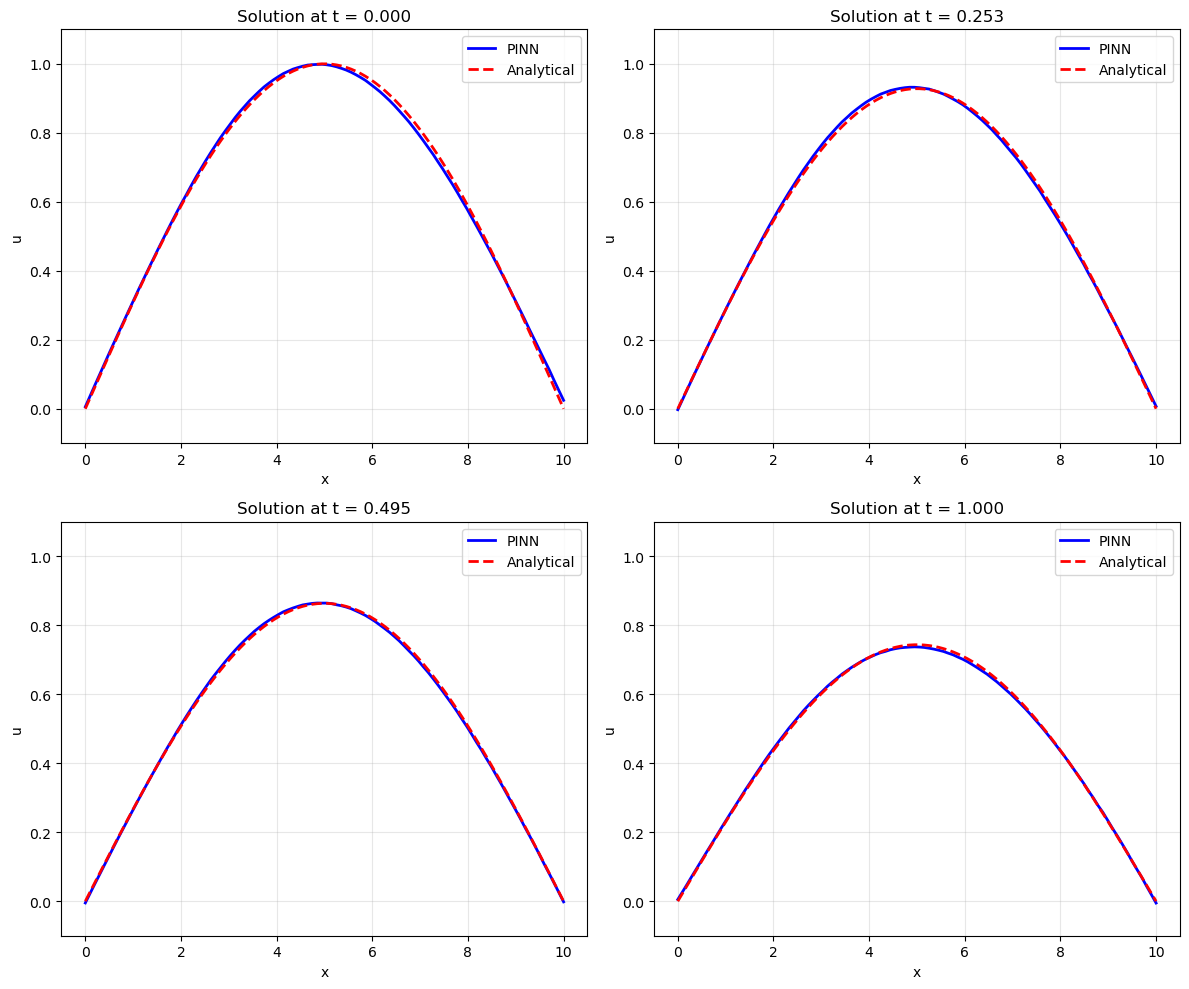

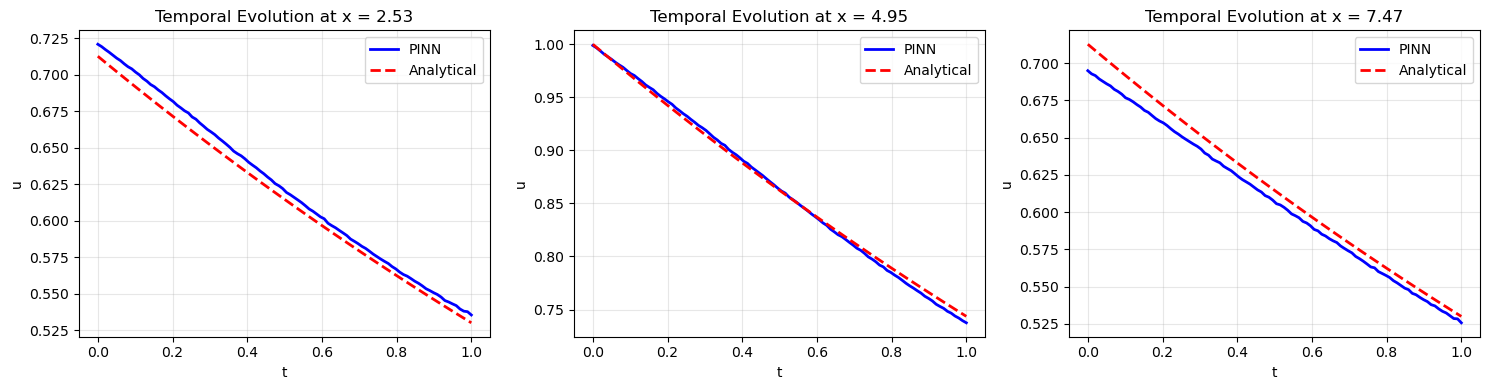

In [18]:
# ============================================================================
# PERFORMANCE EVALUATION: Compare PINN predictions with analytical solution
# ============================================================================

# Create a grid for evaluation
x = geo.x
t = geo.t
X, T = np.meshgrid(x, t)

# Flatten for network evaluation
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# PINN predictions
u_pred = np.array(pinn(XT)).reshape(X.shape)

# Analytical solution: u(x,t) = sin(πx/L) * exp(-π²Dt/L²)
u_exact = np.sin(np.pi * X / L) * np.exp(-D * (np.pi / L)**2 * T)

# ============================================================================
# 8.1 Quantitative Metrics
# ============================================================================

mae = np.mean(np.abs(u_pred - u_exact))
max_error = np.max(np.abs(u_pred - u_exact))
rel_error = np.mean(np.abs(u_pred - u_exact) / (np.abs(u_exact) + 1e-10))

print("\n" + "="*70)
print("QUANTITATIVE PERFORMANCE METRICS")
print("="*70)
print(f"Mean Absolute Error (MAE):     {mae:.6e}")
print(f"Maximum Absolute Error:        {max_error:.6e}")
print(f"Mean Relative Error:           {rel_error:.6e}")
print("="*70 + "\n")

# ============================================================================
# 8.2 Qualitative Assessment: Visualizations
# ============================================================================

# 1. Solution comparison (heatmaps)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# PINN prediction
im1 = axes[0].pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('PINN Prediction: u(x,t)')
plt.colorbar(im1, ax=axes[0], label='u')

# Analytical solution
im2 = axes[1].pcolormesh(X, T, u_exact, shading='auto', cmap='viridis')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('Analytical Solution: u(x,t)')
plt.colorbar(im2, ax=axes[1], label='u')

# Absolute error
residual = np.abs(u_pred - u_exact)
im3 = axes[2].pcolormesh(X, T, residual, shading='auto', cmap='inferno')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Absolute Error: |u_pred - u_exact|')
plt.colorbar(im3, ax=axes[2], label='Error')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. Time slices: u(x, t) at fixed times
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
times = [0.0, 0.25, 0.5, 1.0]

for idx, t_slice in enumerate(times):
    ax = axes[idx // 2, idx % 2]
    
    # Find closest time index
    t_idx = np.argmin(np.abs(t - t_slice))
    
    # Extract predictions and exact solution at this time
    u_pred_slice = u_pred[t_idx, :]
    u_exact_slice = u_exact[t_idx, :]
    
    # Plot
    ax.plot(x, u_pred_slice, label='PINN', color='blue', linewidth=2)
    ax.plot(x, u_exact_slice, label='Analytical', color='red', 
            linestyle='--', linewidth=2)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    # set y-axis limits from -0.1 to 1.1
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(f'Solution at t = {t[t_idx]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. Spatial profiles: u(x, t) at fixed locations
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
x_locations = [L/4, L/2, 3*L/4]

for idx, x_loc in enumerate(x_locations):
    # Find closest x index
    x_idx = np.argmin(np.abs(x - x_loc))
    
    # Extract predictions and exact solution at this location
    u_pred_profile = u_pred[:, x_idx]
    u_exact_profile = u_exact[:, x_idx]
    
    # Plot temporal evolution at this location
    axes[idx].plot(t, u_pred_profile, label='PINN', color='blue', linewidth=2)
    axes[idx].plot(t, u_exact_profile, label='Analytical', color='red', 
                   linestyle='--', linewidth=2)
    axes[idx].set_xlabel('t')
    axes[idx].set_ylabel('u')
    axes[idx].set_title(f'Temporal Evolution at x = {x[x_idx]:.2f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 🚀 ADVANCED / OPTIONAL EXERCISES

The following sections are **optional** and explore more advanced topics:
- **Section 8.3**: Comparison with classical numerical methods (FTCS)
- **Section 9**: Inverse problem - reconstructing initial conditions from measurements

These are excellent extensions if you want to deepen your understanding, but are **not required** for completing the core exercise.

---


Solving with FTCS method...
FTCS stability parameter (should be ≤ 0.5): 0.4909

FTCS Method Errors:
  Mean Absolute Error: 1.253333e-05
  Maximum Error:       3.594964e-05

Comparison:
  PINN MAE:  5.226819e-03
  FTCS MAE:  1.253333e-05
  Winner:    FTCS (lower MAE)


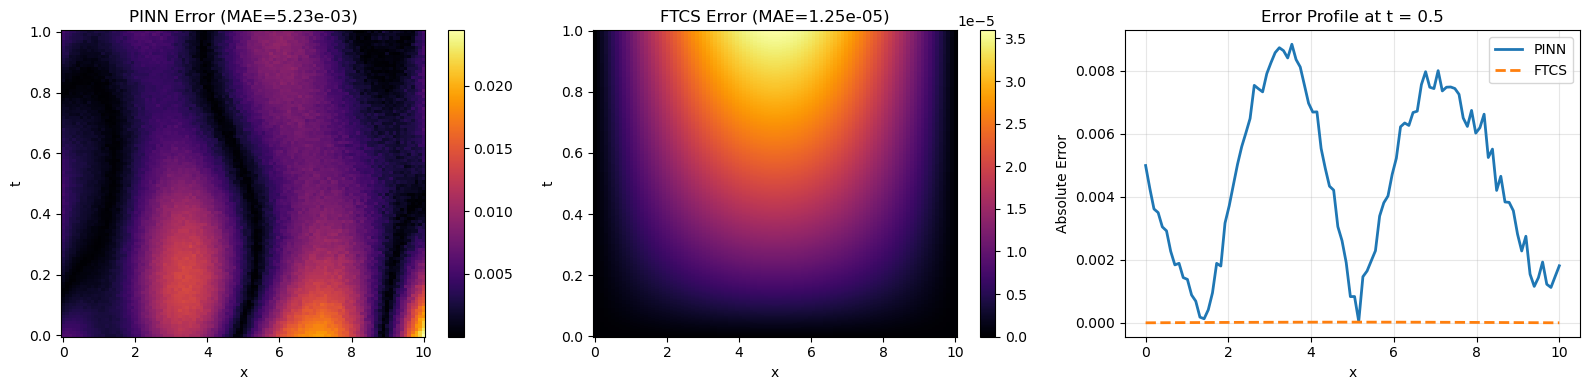

In [19]:
# ============================================================================
# 8.3 OPTIONAL: Comparison with Classical Method: FTCS (Forward-Time Central-Space)
# ============================================================================

def solve_heat_ftcs(L, T, D, nx, nt, ic_func):
    """
    Solve the 1D heat equation using the FTCS explicit finite difference method.
    
    Parameters:
    -----------
    L : float
        Domain length
    T : float
        Final time
    D : float
        Diffusion coefficient
    nx : int
        Number of spatial grid points
    nt : int
        Number of time steps
    ic_func : function
        Initial condition function u(x, 0)
        
    Returns:
    --------
    x : array
        Spatial grid
    t : array
        Time grid
    u : array
        Solution u(x, t)
    """
    # Grid setup
    dx = L / (nx - 1)
    dt = T / (nt - 1)
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    
    # Check stability condition: D*dt/dx² ≤ 0.5
    stability_param = D * dt / dx**2
    print(f"FTCS stability parameter (should be ≤ 0.5): {stability_param:.4f}")
    
    if stability_param > 0.5:
        print("WARNING: FTCS scheme may be unstable!")
    
    # Initialize solution
    u = np.zeros((nt, nx))
    u[0, :] = ic_func(x)

    for n in range(0, nt-1):
        u[n+1,1:-1]= u[n,1:-1]+ stability_param*(u[n,2:]-2*u[n,1:-1]+u[n,0:-2])
        # Boundary conditions
        u[n+1,0]=0
        u[n+1,-1]=0
    
    return x, t, u


# Initial condition function
def ic_sin(x):
    return np.sin(np.pi * x / L)

# Solve using FTCS
print("\nSolving with FTCS method...")
x_ftcs, t_ftcs, u_ftcs = solve_heat_ftcs(L, t_end, D, nx=100, nt=600, ic_func=ic_sin)

# Convert to JAX arrays for comparison
u_ftcs_jax = np.array(u_ftcs)
X_ftcs, T_ftcs = np.meshgrid(x_ftcs, t_ftcs)

# Compute analytical solution on FTCS grid
u_exact_ftcs = np.sin(np.pi * X_ftcs / L) * np.exp(-D * (np.pi / L)**2 * T_ftcs)

# Compute errors
ftcs_mae = np.mean(np.abs(u_ftcs_jax - u_exact_ftcs))
ftcs_max_error = np.max(np.abs(u_ftcs_jax - u_exact_ftcs))

print(f"\nFTCS Method Errors:")
print(f"  Mean Absolute Error: {ftcs_mae:.6e}")
print(f"  Maximum Error:       {ftcs_max_error:.6e}")

print(f"\nComparison:")
print(f"  PINN MAE:  {mae:.6e}")
print(f"  FTCS MAE:  {ftcs_mae:.6e}")
print(f"  Winner:    {'PINN' if mae < ftcs_mae else 'FTCS'} (lower MAE)")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# PINN error
im1 = axes[0].pcolormesh(X, T, np.abs(u_pred - u_exact), shading='auto', cmap='inferno')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title(f'PINN Error (MAE={mae:.2e})')
plt.colorbar(im1, ax=axes[0])

# FTCS error
im2 = axes[1].pcolormesh(X_ftcs, T_ftcs, np.abs(u_ftcs_jax - u_exact_ftcs), 
                         shading='auto', cmap='inferno')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title(f'FTCS Error (MAE={ftcs_mae:.2e})')
plt.colorbar(im2, ax=axes[1])

# Error comparison at t=0.5
t_compare = 0.5
t_idx_pinn = np.argmin(np.abs(t - t_compare))
t_idx_ftcs = np.argmin(np.abs(t_ftcs - t_compare))

axes[2].plot(x, np.abs(u_pred[t_idx_pinn, :] - u_exact[t_idx_pinn, :]), 
             label='PINN', linewidth=2)
axes[2].plot(x_ftcs, np.abs(u_ftcs[t_idx_ftcs, :] - u_exact_ftcs[t_idx_ftcs, :]), 
             label='FTCS', linewidth=2, linestyle='--')
axes[2].set_xlabel('x')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title(f'Error Profile at t = {t_compare}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 🔬 ADVANCED: Inverse Problem Challenge


### 9.1 Diffusion in Fricke Gel – 1D Inverse Problem

The simplest diffusion experiment involving Fricke hydrogel consists of a small rod that is half-irradiated, as shown in the figure below. In this case, a chelating agent—which induces color changes in accordance with the amount of ferric ions—was added to the gel. It follows that dose estimation can be performed through optical measurements of absorbance.  
In other words, absorbance (what you measure) is proportional to the amount of ferric ions, which in turn is proportional to the absorbed dose of ionizing radiation.

![1d_fricke_gel](./images/fricke_gel_irr.png)

After irradiation, ferric ions diffuse within the gel matrix, causing the loss of the initial shape, as shown in the animation below.

![1d_evolution](./images/1D_evolution.gif)

Since ions cannot move outside the gel, the concentration flux at the boundaries is zero. This means that:

$$
\frac{\partial}{\partial x}A(x,t) = 0 \quad \text{with} \quad x = \{0, L\}
$$  
(*Von Neumann boundary condition*)

where $A(x,t)$ is the measured absorbance at position $x$ and time $t$.  

**The main physical consequence is that the total amount of ferric ions does not change, and consequently, the total absorbed dose remains constant as well.**


**Task 9.1:** Recover the initial distribution from a later measurement (inverse problem)

This advanced exercise explores one of PINNs' most powerful capabilities: solving inverse problems.




---

### 9.2 Problem Setup

In [experimental_data folder](./experimental_data/) 4 sets at $t = \{1,4,7,10\}\ h$ of Absorbance as a function of position are given.

- **First experimental distribution:** `A(x, t)` at time `t = 1.0 h` (Initial distribution cannot be measured)
- **Diffused distribution:** `A(x, t)` at later times `t = t_measurement = [4.0, 7.0, 10.0] h`
- **Diffusion coefficient:** it was experimentally determined as `D = 0.249 mm²/h`
- **Boundary conditions:** `∂A/∂x(0, t) = ∂A/∂x(L, t) = 0` for all `t > 0`

**Your goal:** Starting from the measurement at `t = t_measurement`, reconstruct the initial distribution at `t = 1.0 h` (predicting `t = 0.0 h` is possible but ground truth is not provided).

This is an **inverse problem** (going backward in time) and is generally ill-posed for the heat equation due to its irreversible nature.

---

### 9.3 Implementation Strategy

**Modifications to your PINN:**

1. **Change the supervised data:**
   - Instead of using the initial condition `A(x, 0) = sin(πx/L)` as training data...
   - Use the measurement at `t = t_measurement` as your supervised constraint
   - New loss: `L_data = mean((NN(x, t_measurement) - u_measured(x, t_measurement))²)`

2. **Predict backward:**
   - Train the network to satisfy the PDE throughout `t ∈ [0, t_measurement]`
   - The network should learn to "reverse" the diffusion process
   - After training, evaluate `NN(x, 0)` to get the reconstructed initial condition

3. **Handle discrete measurements:**
   - **Challenge:** You only have discrete measurement points, not a continuous function
   - **Solution:** Use interpolation to evaluate `u_measured` at arbitrary points
   - Suggested: [Scipy interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html) (e.g., `scipy.interpolate.interp1d` or `scipy.interpolate.CubicSpline`)

---

### 9.4 Modified Loss Function

Your new total loss should be:

$$\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{data}$$

Where:
- `L_PDE`: Same as before (enforces heat equation throughout the domain)
- `L_BC`: Must be modified for Neumann BCs: `∂u/∂x(0, t) = ∂u/∂x(L, t) = 0`
- `L_data`: New supervised loss using measurements at `t = t_measurement`

Note: You're replacing `L_IC` (initial condition supervision) with `L_data` (measurement supervision).

---

### 9.5 Key Questions to Explore

**Question 9.1:** *How far back in time can you reliably reconstruct?*

Experiment with different values of `t_measurement`:
- Start with small values (e.g., `t_measurement = 4.0 h`)
- Gradually increase to larger values (e.g., `7.0 h`, `10.0 h`)
- Additional measurements at longer times can be generated using the FTCS scheme
- At what point does reconstruction fail or become very inaccurate?

**Factors to investigate:**
1. **Reconstruction error vs. time:**
   - Plot reconstruction error as a function of `t_measurement`
   - Observe when error grows unacceptably large

2. **Role of noise:** (can be skipped with real experimental data)
   - Add Gaussian noise to the measurement data: `A_noisy = A_measured + ε·N(0,1)`
   - How does noise affect reconstruction quality?
   - Try different noise levels

3. **Regularization:**
   - Can you improve reconstruction by adding regularization terms to the loss?
   - Example: Penalize roughness of the initial condition

4. **Physical intuition:**
   - Why does the heat equation make backward reconstruction difficult?
   - Think about information loss during diffusion
   - How does this relate to the second law of thermodynamics?

---

### 9.6 Expected Challenges

1. **Training instability:**
   - Inverse problems are typically more difficult to train
   - You may need: smaller learning rates, more iterations, better initialization

2. **Non-uniqueness:**
   - Multiple initial conditions might produce similar measurements
   - The PINN might converge to different solutions with different random seeds

3. **Sensitivity to hyperparameters:**
   - Loss weighting becomes more critical
   - Network architecture may need adjustment

**Tips:**
- Start with small `t_measurement` where the problem is easier
- Use multiple random seeds and compare results
- Visualize intermediate solutions during training to debug issues

---

### 9.7 Extension Ideas

If you complete the basic inverse problem, consider:
1. **Unknown diffusion coefficient:** Simultaneously learn `D` and initial condition
2. **Sparse measurements:** Use only a few spatial points at `t_measurement`
3. **Multiple time measurements:** Use data at several different times
4. **2D heat equation:** Extend to two spatial dimensions

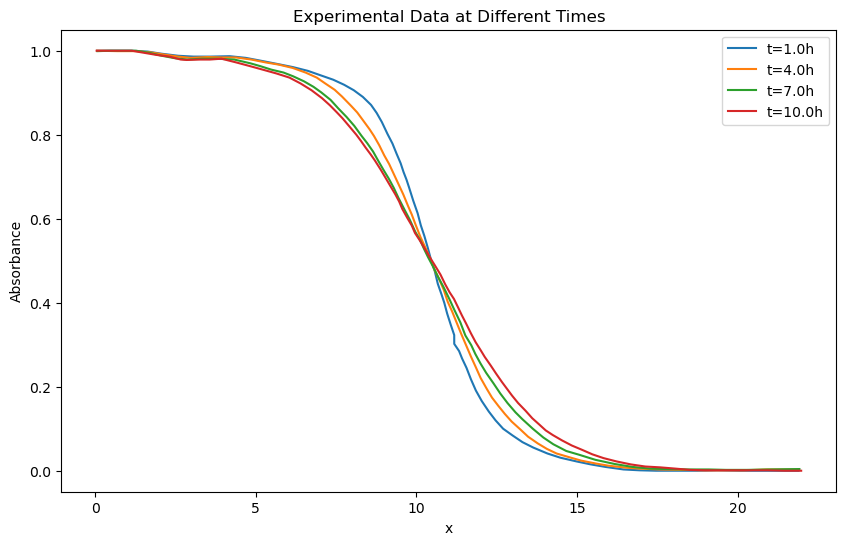

In [20]:
# ============================================================================
# 9. ADVANCED/OPTIONAL: INVERSE PROBLEM
# ============================================================================
# Goal: Recover initial condition from a measurement at later time

#loading data
data_0=np.load('experimental_data/data_0.npz') #experimental data at t=1.0h
data_1=np.load('experimental_data/data_1.npz') #experimental data at t=4.0h
data_2=np.load('experimental_data/data_2.npz') #experimental data at t=7.0h
data_3=np.load('experimental_data/data_3.npz') #experimental data at t=10.0h

#plotting data
plt.figure(figsize=(10,6))
plt.plot(data_0['x'], data_0['y'], label='t=1.0h')
plt.plot(data_1['x'], data_1['y'], label='t=4.0h')
plt.plot(data_2['x'], data_2['y'], label='t=7.0h')
plt.plot(data_3['x'], data_3['y'], label='t=10.0h')
plt.xlabel('x')
plt.ylabel('Absorbance')
plt.title('Experimental Data at Different Times')
plt.legend()

INVERSE PROBLEM: RECONSTRUCTING INITIAL CONDITION
  Measurement points: 100 at t=7.0h,  Diffusion Coeff.: D=0.249mm²/h


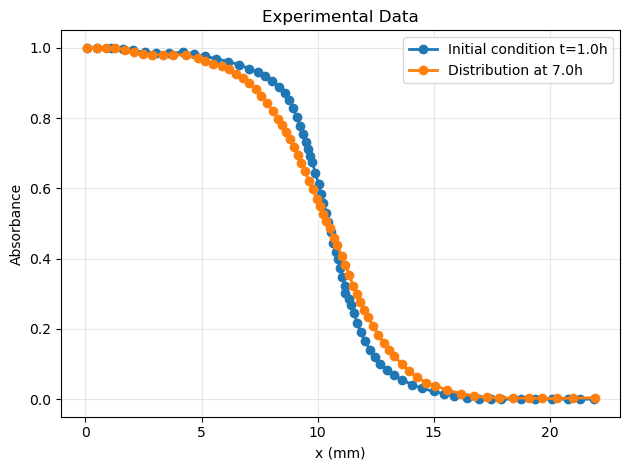

In [21]:
# time of measurement in hours choose one of the available times [4.0,7.0,10.0]
t_measurement = 7.0

D = 0.249 # diffusion coefficient from experimental analysis

x_ini , A_ini = data_0['x'] , data_0['y']  # initial condition at t=1.0h 

if t_measurement == 4.0:
    x_measure, A_measure = data_1['x'] , data_1['y']
elif t_measurement == 7.0:
    x_measure, A_measure = data_2['x'] , data_2['y']
elif t_measurement == 10.0:
    x_measure, A_measure = data_3['x'] , data_3['y']

print("="*70)
print("INVERSE PROBLEM: RECONSTRUCTING INITIAL CONDITION")
print("="*70)


print(f"  Measurement points: {len(x)} at t={t_measurement}h,  Diffusion Coeff.: D={D}mm²/h")

# Visualize the data
plt.plot(x_ini, A_ini, 'o-', label='Initial condition t=1.0h', linewidth=2)
plt.xlabel('x')
plt.ylabel('Absorbance')
plt.plot(x_measure, A_measure, 'o-', label=f'Distribution at {t_measurement}h', linewidth=2)
plt.xlabel('x (mm)')
plt.ylabel('Absorbance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Experimental Data')




plt.tight_layout()
plt.show()

In [22]:
# ============================================================================
# Step 2: Create interpolation function for measurements
# ============================================================================

from scipy.interpolate import CubicSpline


cs=CubicSpline(x_measure, A_measure) #Once created, this object can be used to evaluate the interpolated values at any point within the range of x_measure


# ============================================================================
# Step 3: Create loss data function, modified BC_loss and PDE loss
# ============================================================================


@tf.function
def loss_data(net,x_data,t_data,true_data):
    """
    Compute the data driven loss.
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x_data : array of spatial points
    t_data : array of time points, with t = 1.0
    true_data : Interpolated point values: A(x_data, x_data)
        
    Returns:
    --------
    loss : float
        Mean squared error between predictions and intepolated data
    """    
    uic=net(tf.stack([x_data,t_data],-1),training=True)
    IC_loss=tf.reduce_mean(tf.square(uic-true_data))
    return IC_loss

@tf.function
def loss_bc_inverse(net,x,t):
    """
    Compute the boundary condition loss: L_BC.
    
    Enforces Neumann BC: u_x(0, t) = u_x(L, t) = 0
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x : array of spatial points, where x ∈ {0, L} 
    t : array of time internal points
        
    Returns:
    --------
    loss : float
        Mean squared boundary predictions (should be zero)
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        u=net(tf.stack([x,t],-1), training=True)
    u_x=tape.gradient(u,x)    #Here we compute the spatial derivative at the boundary
    BC_loss=tf.reduce_mean(tf.square(u_x)) # Since Neumann BC is u_x=0, we penalize any non-zero predictions
    return BC_loss


def PDE_inverse(network, point_int, point_BC, point_data, D,cs):
    """
    Compute the total physics-informed loss.
    
    L_total = L_PDE + L_BC + L_data
    
    Parameters:
    -----------
    network : Pinn model
        keras model
    points_int : array
        Interior domain points
    points_BC : array
        Boundary points
    points_data : array
        Initial condition points
    D : float
        Diffusion coefficient
    cs : interpolating function
        Cubic spline interpolation of measurement data
        
    Returns:
    --------
    total : float
        Total loss value
    components : tuple
        Individual loss components (l_pde, l_bc, l_data) for monitoring
    """

    def data_interpolation(x,cs):
        y=cs(x)
        return np.expand_dims(y,-1) # needed to match the shape


    #Since we are running loss computation under @tf.funtion its better working only with tensors
    x=tf.constant(point_int[:,0], tf.float32)
    t=tf.constant(point_int[:,1], tf.float32)
    D=tf.constant(D, tf.float32)
    pde_loss=loss_pde(network,x,t,D)

    xbc=tf.constant(point_BC[:,0], tf.float32)
    tbc=tf.constant(point_BC[:,1], tf.float32)
    BC_loss=loss_bc_inverse(network,xbc,tbc)

    xdata=tf.constant(point_data[:,0], tf.float32)
    tdata=tf.constant(point_data[:,1], tf.float32)
    true_data=tf.cast(data_interpolation(point_data[:,0],cs),tf.float32)
    IC_loss=loss_data(network,xdata,tdata,true_data)

    total_loss=pde_loss+BC_loss+IC_loss
    return total_loss,pde_loss,BC_loss, IC_loss




In [23]:
# ============================================================================
# Step 4: Modify the training loop for the inverse problem
# ============================================================================

def train_pinn_inverse(pinn, geo, D, n_epochs=5000, N1=1000, N2=200, N4=200, learning_rate=1e-3, checkpoint_dir = None, summary_function=None, fine_tune : bool = False, t_m = None ,cs=None):
    """
    Train the Physics-Informed Neural Network.
    
    Parameters:
    -----------
    pinn : Pinn
        PINN object to train
    geo : Geometry
        Geometry object for sampling points
    D : float
        Diffusion coefficient
    n_epochs : int
        Number of training iterations
    N1, N2, N4 : int
        Number of interior, boundary, and initial condition points per epoch
    learning_rate : float
        Adam optimizer learning rate
    checkpoint_dir : str
        Directory to save model checkpoints (optional). If None, checkpoints are savede in the folder './training_PINN'.
    summary_function : function
        Function to log training summaries (optional)
    fine_tune : bool
        If True, continue training from existing weights
    t_m : float
        Time of measurement
    cs : interpolating function
        Cubic spline interpolation of measurement data
        
    Returns:
    --------
    trained_pinn : Pinn
        Trained PINN model (at the last epoch)
    loss_history : list
        Total loss at each epoch
    loss_components : dict
        History of individual loss components
    """
    # Loss history for monitoring
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'data': []}

    # Initialize Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if fine_tune:
        print("Computing initial loss before fine-tuning...")
        initial_loss= PDE_inverse(pinn,
                  geo.sample_interior(N1),
                  geo.sample_boundary(N2),
                  geo.sample_at_time(N4, t_m),
                  D,cs)
        best_loss= initial_loss[0].numpy()
        loss_history.append(best_loss)
        print(f"Initial total loss: {best_loss:.6f}")
        loss_components['pde'].append(initial_loss[1].numpy())
        loss_components['bc'].append(initial_loss[2].numpy())
        loss_components['data'].append(initial_loss[3].numpy())
    else:
        best_loss = np.inf

    print(f"Starting training for {n_epochs} epochs...")
    print(f"Sampling: N1={N1} (interior), N2={N2} (boundary), N4={N4} (initial)\n")
    
    # Setup checkpointing
    print('Setting up checkpointing...')
    if checkpoint_dir is None:
        checkpoint_dir = './training_PINN_inverse'
    print(f'Checkpoint directory: {checkpoint_dir}')
    checkpoint=tf.train.Checkpoint(
                generator_optimizer=optimizer,
                generator=pinn
                    )
    manager=tf.train.CheckpointManager(checkpoint,checkpoint_dir, max_to_keep=1)

    
    for epoch in range(n_epochs):
        # Sample points
        points_interior = geo.sample_interior(N1)
        points_boundary = geo.sample_boundary(N2)
        points_data = geo.sample_at_time(N4, t_m)

        with tf.GradientTape() as tape:
            total_loss, pde_loss, bc_loss, data_loss = PDE_inverse(
                pinn, points_interior, points_boundary, points_data, D,cs)
        # Record losses
        loss_history.append(total_loss.numpy())
        loss_components['pde'].append(pde_loss.numpy())
        loss_components['bc'].append(bc_loss.numpy())
        loss_components['data'].append(data_loss.numpy())
        
        # Compute gradients and update weights
        gradients = tape.gradient(total_loss, pinn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

        if total_loss<best_loss:
            #print('Find new best! Model checkpoint saving')
            manager.save()

        # Log summaries if function provided
        if summary_function:
            summary_function(epoch, total_loss, pde_loss, bc_loss, data_loss)

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{n_epochs} - Total Loss: {total_loss:.6f} "
                    f"(PDE: {pde_loss:.6f}, BC: {bc_loss:.6f}, DATA: {data_loss:.6f})")
    
    print("Training completed!")
    return pinn, loss_history, loss_components

In [24]:
#reinitialize geometry
L= x_measure[-1] - x_measure[0]  # domain length from data
geo = Geometry(L=L,t_end=t_measurement,Nt=200, resample=True)

# Create new PINN for inverse problem
print("\nInitializing new PINN for inverse problem...")
layers_inverse = [10, 20, 200, 20, 10]  # Slightly larger network
pinn_inverse = pinn_model(input_shape=(2,),
                  output_shape=1,
                  hidden_layers=layers_inverse,
                  activation='tanh',
                  initializer_seed=1234)

#reinitialize summary writers for inverse problem
log_dir_inverse="logs_inverse/"
summary_writer_inv = tf.summary.create_file_writer(
log_dir_inverse + "total_loss/")
summary_writer_2_inv = tf.summary.create_file_writer(
log_dir_inverse + 'pde_loss/')
summary_writer_3_inv = tf.summary.create_file_writer(
log_dir_inverse + 'data_loss/')
summary_writer_4_inv = tf.summary.create_file_writer(
log_dir_inverse + 'bc_loss/')

def summary_function_inverse(epoch, total_loss, pde_loss, bc_loss, ic_loss):
    with summary_writer_inv.as_default():
        tf.summary.scalar('total_loss', total_loss, step=epoch+1)
    with summary_writer_2_inv.as_default():
        tf.summary.scalar('pde_loss', pde_loss, step=epoch+1)
    with summary_writer_3_inv.as_default():
        tf.summary.scalar('data_loss', ic_loss, step=epoch+1)
    with summary_writer_4_inv.as_default():
        tf.summary.scalar('bc_loss', bc_loss, step=epoch+1)

#first kill any existing tensorboard instances
!kill $(lsof -t -i:6006) 2>/dev/null || echo "No existing tensorboard instances."

%load_ext tensorboard        


Initializing new PINN for inverse problem...
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
#this command launches tensorboard platform
#here we will see the losses during training
#if it doesn't appear try run twice
#set on time series
#set Reload data
%tensorboard --logdir=$log_dir_inverse

TRAINING PHYSICS-INFORMED NEURAL NETWORK FOR INVERSE PROBLEM
Starting training for 1000 epochs...
Sampling: N1=20000 (interior), N2=1000 (boundary), N4=20000 (initial)

Setting up checkpointing...
Checkpoint directory: ./training_PINN_inverse
Epoch 1/1000 - Total Loss: 0.282758 (PDE: 0.000130, BC: 0.020450, DATA: 0.262177)
Epoch 100/1000 - Total Loss: 0.010207 (PDE: 0.008754, BC: 0.000345, DATA: 0.001108)
Epoch 200/1000 - Total Loss: 0.005853 (PDE: 0.005312, BC: 0.000155, DATA: 0.000386)
Epoch 300/1000 - Total Loss: 0.003281 (PDE: 0.002844, BC: 0.000151, DATA: 0.000286)
Epoch 400/1000 - Total Loss: 0.002320 (PDE: 0.001846, BC: 0.000086, DATA: 0.000388)
Epoch 500/1000 - Total Loss: 0.001790 (PDE: 0.001310, BC: 0.000076, DATA: 0.000404)
Epoch 600/1000 - Total Loss: 0.001390 (PDE: 0.000990, BC: 0.000056, DATA: 0.000344)
Epoch 700/1000 - Total Loss: 0.001088 (PDE: 0.000784, BC: 0.000046, DATA: 0.000258)
Epoch 800/1000 - Total Loss: 0.000868 (PDE: 0.000557, BC: 0.000033, DATA: 0.000278)
Epo

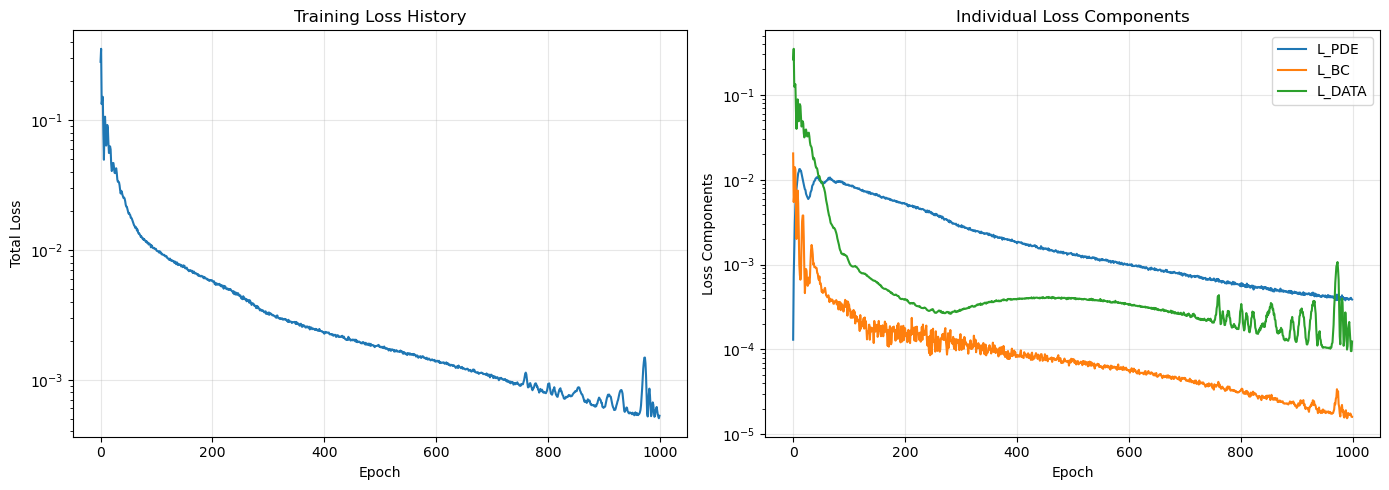

In [26]:
# Train the PINN

print("="*70)
print("TRAINING PHYSICS-INFORMED NEURAL NETWORK FOR INVERSE PROBLEM")
print("="*70)


# Train
pinn_inverse, loss_history, loss_components = train_pinn_inverse(
    pinn_inverse, geo, D,
    n_epochs=1000, 
    N1=20000, N2=1000, N4=20000,
    learning_rate=0.001,
    summary_function=summary_function_inverse,
    t_m = t_measurement,
    cs=cs
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total loss
axes[0].plot(loss_history, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Loss History')
axes[0].grid(True, alpha=0.3)

# Individual components
axes[1].plot(loss_components['pde'], label='L_PDE', linewidth=1.5)
axes[1].plot(loss_components['bc'], label='L_BC', linewidth=1.5)
axes[1].plot(loss_components['data'], label='L_DATA', linewidth=1.5)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


RECONSTRUCTION RESULTS
3/3 [==============================] - 0s 2ms/step

Reconstruction at t = 0 (going back 7.0 in time):
  Mean Absolute Error: 1.206872e-01
  Maximum Error:       2.869240e-01


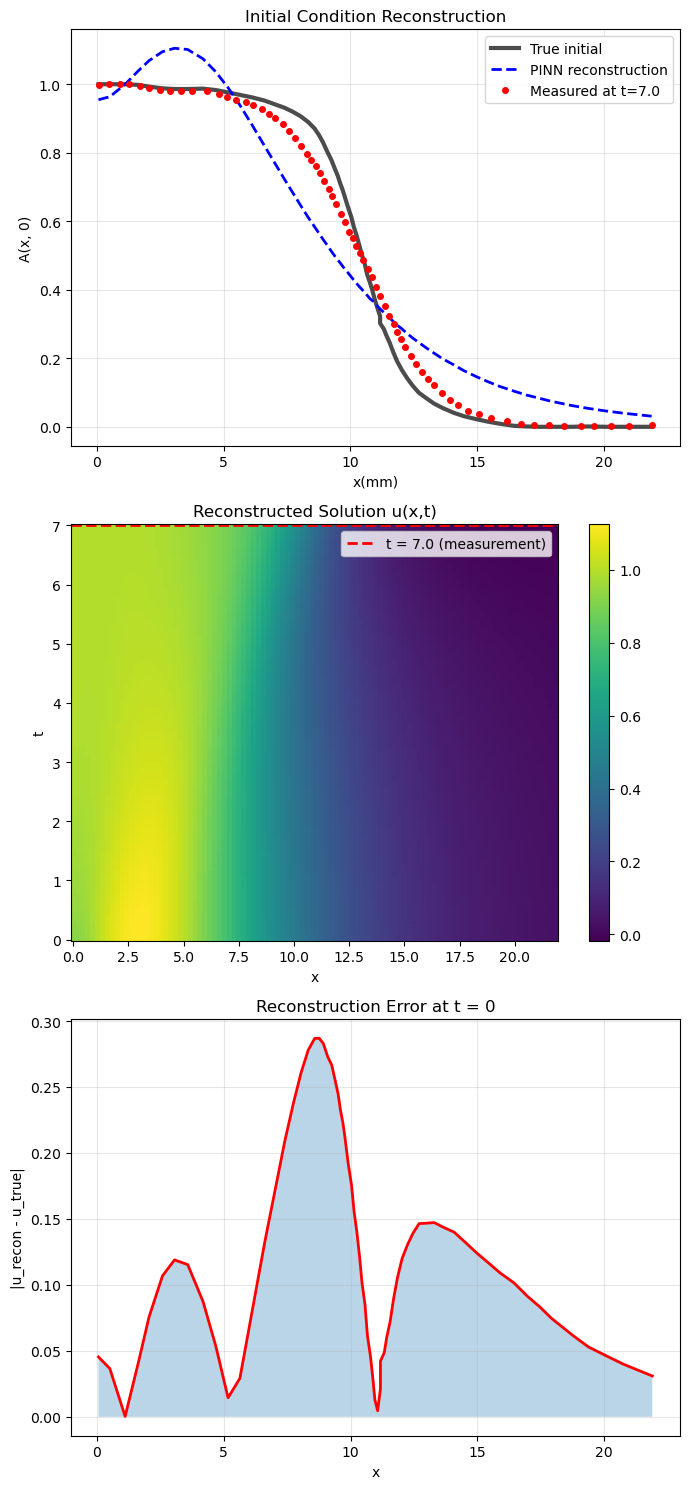


💡 Try changing t_measurement to see how reconstruction quality degrades!
   Current value: 7.0
   Suggested experiments: 0.1, 0.3, 0.5, 1.0, 2.0


In [27]:
# ============================================================================
# Step 4: Evaluate reconstruction
# ============================================================================

print("\n" + "="*70)
print("RECONSTRUCTION RESULTS")
print("="*70)

# Reconstruct initial condition
x_recon = x_ini  # use initial x points for reconstruction
t_ini = 1.0  # initial time corresponding to A_ini
t_zero = np.ones_like(x_recon)* t_ini
points_initial_recon = np.stack((x_recon, t_zero),-1)

u_initial_reconstructed = pinn_inverse.predict(points_initial_recon)
u_initial_reconstructed = u_initial_reconstructed.reshape(x_recon.shape[-1])


# Compute reconstruction error
recon_mae = np.mean(np.abs(u_initial_reconstructed - A_ini))
recon_max_error = np.max(np.abs(u_initial_reconstructed - A_ini))

print(f"\nReconstruction at t = 0 (going back {t_measurement} in time):")
print(f"  Mean Absolute Error: {recon_mae:.6e}")
print(f"  Maximum Error:       {recon_max_error:.6e}")
print("="*70)

# Visualize reconstruction
fig, axes = plt.subplots(3, 1, figsize=(7, 15))

# 1. Initial condition reconstruction
axes[0].plot(x_recon, A_ini, 'k-', 
                label='True initial', linewidth=3, alpha=0.7)
axes[0].plot(x_recon, u_initial_reconstructed, 'b--', 
                label='PINN reconstruction', linewidth=2)
axes[0].plot(x_measure, A_measure, 'ro', 
                label=f'Measured at t={t_measurement}', markersize=4)
axes[0].set_xlabel('x(mm)')
axes[0].set_ylabel('A(x, 0)')
axes[0].set_title('Initial Condition Reconstruction')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# 3. Full solution in (x,t) space
x_full = geo.x
t_full = geo.t
X_full, T_full = np.meshgrid(x_full, t_full)
XT_full = np.hstack((X_full.flatten()[:, None], T_full.flatten()[:, None]))
u_inverse_full = np.array(pinn_inverse(XT_full)).reshape(X_full.shape)

im = axes[1].pcolormesh(X_full, T_full, u_inverse_full, shading='auto', cmap='viridis')
axes[1].axhline(t_measurement, color='red', linestyle='--', 
                   linewidth=2, label=f't = {t_measurement} (measurement)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('Reconstructed Solution u(x,t)')
axes[1].legend()
plt.colorbar(im, ax=axes[1])

# 4. Reconstruction error
error_recon = np.abs(u_initial_reconstructed - A_ini)
axes[2].plot(x_recon, error_recon, 'r-', linewidth=2)
axes[2].fill_between(x_recon, 0, error_recon, alpha=0.3)
axes[2].set_xlabel('x')
axes[2].set_ylabel('|u_recon - u_true|')
axes[2].set_title('Reconstruction Error at t = 0')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Try changing t_measurement to see how reconstruction quality degrades!")
print(f"   Current value: {t_measurement}")
print(f"   Suggested experiments: 0.1, 0.3, 0.5, 1.0, 2.0")

---

# 10. 🔬 ADVANCED: 2D Fricke Gel Inverse Problem

In this final advanced exercise, we extend our PINN capabilities to solve a realistic **2D inverse problem** inspired by medical physics: reconstructing the initial dose distribution in a Fricke gel dosimeter after diffusion has occurred.

## 10.1 Physical Background

**Fricke gel dosimeters** are used in radiation therapy to measure 3D dose distributions:
- Iron ions ($Fe^{2+}$) in gel are oxidized to $Fe^{3+}$ by ionizing radiation
- $Fe^{3+}$ concentration is proportional to absorbed dose
- MRI or optical scanning can map the $Fe^{3+}$ distribution

**The Challenge:** 
- Diffusion blurs the dose distribution between irradiation and measurement
- We measure a *diffused* distribution, but need the *original* dose for treatment verification
- This is an **inverse problem**: going backward in time to recover initial conditions

**Governing Equation (2D Heat/Diffusion):**

$$\frac{\partial u}{\partial t} = D \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$$

Where:
- $u(x,y,t)$ is the $Fe^{3+}$ concentration (proportional to dose)
- $D$ is the diffusion coefficient
- Domain: $(x,y) \in [0, L_x] \times [0, L_y]$, $t \in [0, T_{max}]$
- Boundary conditions: Neumann (no-flux) at all boundaries

**Our Goal:** Given $u(x,y,T_{measure})$ (measurement after diffusion), reconstruct $u(x,y,0)$ (original dose distribution)

---

2D FRICKE GEL INVERSE PROBLEM - DATA GENERATION

Domain: 1.0 x 1.0
Diffusion coefficient: D = 0.005
Spatial resolution: dx = 0.01, dy = 0.01
Grid size: (100, 100)


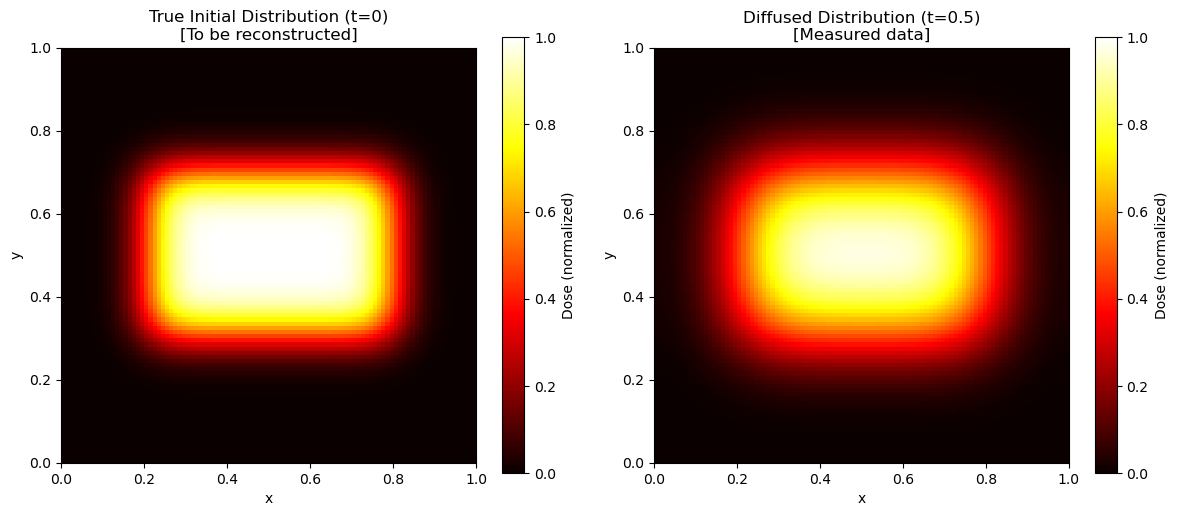


Data generated successfully!
Initial distribution range: [0.0000, 0.9996]
Diffused distribution range: [0.0000, 0.9698]


In [28]:
# ============================================================================
# 10.2 Generate Synthetic 2D Data using FTCS
# ============================================================================

print("="*70)
print("2D FRICKE GEL INVERSE PROBLEM - DATA GENERATION")
print("="*70)

from FTCS.FTCS_scheme import diffusion_2D
from FTCS.Initial_condition import rectangle

# Problem parameters
Lx = 1.0      # domain size in x
Ly = 1.0      # domain size in y
Tmax = 0.5    # maximum time
D_2d = 0.005  # diffusion coefficient
dx = 0.01     # spatial resolution x
dy = 0.01     # spatial resolution y

# Rectangle initial condition parameters (dose distribution)
xc = 0.5      # center x
yc = 0.5      # center y
W = 0.3       # width
H = 0.2       # height

print(f"\nDomain: {Lx} x {Ly}")
print(f"Diffusion coefficient: D = {D_2d}")
print(f"Spatial resolution: dx = {dx}, dy = {dy}")

# Initialize FTCS solver
geo_ftcs = diffusion_2D(Lx, Ly, Tmax, dx, dy, D_2d)

# Create smooth rectangular initial condition
ini_2d = rectangle(geo_ftcs, xc, yc, H, W, T_evo=0.3)
geo_ftcs.set_initial_condition(ini_2d)

print(f"Grid size: {ini_2d.shape}")

# Visualize initial condition
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(ini_2d, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
plt.colorbar(label='Dose (normalized)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Initial Distribution (t=0)\n[To be reconstructed]')

# Evolve to measurement time
t_measure_2d = 0.5  # measurement time
geo_ftcs_measure = diffusion_2D(Lx, Ly, t_measure_2d, dx, dy, D_2d)
geo_ftcs_measure.set_initial_condition(ini_2d)
final_2d = geo_ftcs_measure.Neumann_evo()

plt.subplot(1, 2, 2)
plt.imshow(final_2d, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
plt.colorbar(label='Dose (normalized)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Diffused Distribution (t={t_measure_2d})\n[Measured data]')

plt.tight_layout()
plt.show()

print(f"\nData generated successfully!")
print(f"Initial distribution range: [{ini_2d.min():.4f}, {ini_2d.max():.4f}]")
print(f"Diffused distribution range: [{final_2d.min():.4f}, {final_2d.max():.4f}]")

## 10.3 2D Geometry Class for PINN

We need to extend our geometry class to handle 2D spatial domains. The main differences from 1D:
- Input coordinates: $(x, y, t)$ instead of $(x, t)$
- Domain boundaries: 4 edges (left, right, bottom, top) instead of 2 points
- Neumann boundary conditions: $\frac{\partial u}{\partial n} = 0$ at all boundaries

In [29]:
# ============================================================================
# 2D Geometry
# ============================================================================

#That you developed for 1D case can be easely adapted for a 2D geometry
#Keep in mind that for Von Neumann condition you have:
# n · ∇u=0, with n normal versor along the border.
# n is different at each border!
# in particular on the left you will have:
# ∂u/∂x = 0       but ∂u/∂y is not necessary 0!


class Geometry2D():
    def __init__(self, Lx=1,Ly=1,t_start=0,t_end=1,resample=True,seed=500):
        '''
        This class generates the whole geometry of the problem
        L        : higher x
        L        : highest y
        t_start      : lower time
        t_end      : higher time
        resample  : resample data at each call?
        seed      : random seed for replication

        '''
        
        
        self.Lx=Lx
        self.Ly=Ly
        self.t_start=t_start
        self.t_end=t_end
        self.resample=resample
        self.seed=seed

    def sample_interior(self,n_point):
        self.resample_seed()    
        np.random.seed(self.seed)
        x=np.random.uniform(0,self.Lx,n_point)
        y=np.random.uniform(0,self.Ly,n_point)
        t=np.random.uniform(self.t_start,self.t_end,n_point)
        return np.stack([x,y,t],-1)

    def sample_boundary(self,n_point):
        """
        Return a dict, size=4, of borer points.
        keys:
        - left
        - right
        - down
        - up

        """
        self.resample_seed()
        np.random.seed(self.seed)
        #left border
        y_left=np.random.uniform(0,self.Ly,n_point//4)
        t=np.random.uniform(self.t_start,self.t_end,n_point//4)
        left=np.stack([np.zeros_like(y_left),y_left,t],-1)

        #right border
        y_right=np.random.uniform(0,self.Ly,n_point//4)
        t=np.random.uniform(self.t_start,self.t_end,n_point//4)
        right=np.stack([self.Lx*np.ones_like(y_right),y_right,t],-1)
        
        #bottom border
        x_down=np.random.uniform(0,self.Lx,n_point//4)
        t=np.random.uniform(self.t_start,self.t_end,n_point//4)
        down=np.stack([x_down,np.zeros_like(x_down),t],-1)
        
        #top border
        x_up=np.random.uniform(0,self.Lx,n_point//4)
        t=np.random.uniform(self.t_start,self.t_end,n_point//4)
        up=np.stack([x_up,self.Ly*np.ones_like(x_up),t],-1)

        border={'left': left, 'right':right, 'down':down, 'up':up}
        
        return border
    
    def sample_initial(self,n_point):
        self.resample_seed()
        np.random.seed(self.seed)
        x=np.random.uniform(0,self.Lx,n_point)
        y=np.random.uniform(0,self.Ly,n_point)
        t=np.zeros_like(x)
        return np.stack([x,y,t],-1)
    
    def sample_at_time(self,n_point, T):
        self.resample_seed()
        np.random.seed(self.seed)
        x=np.random.uniform(0,self.Lx,n_point)
        y=np.random.uniform(0,self.Ly,n_point)
        t=np.ones_like(x)*T
        return np.stack([x,y,t],-1)
    
    def resample_seed(self):
        if self.resample:
            self.seed=np.random.randint(1000000)

print("✓ Geometry2D class defined")

✓ Geometry2D class defined


In [30]:
geo2=Geometry2D(Lx=Lx,Ly=Ly,resample=True)

## 10.4 2D Neural Network Architecture

The PINN for 2D diffusion has:
- **Input:** 3 coordinates $(x, y, t)$
- **Output:** 1 value $u(x, y, t)$
- **Architecture:** Similar to 1D but may need more capacity for 2D spatial patterns

In [31]:
# ============================================================================
# 2D PINN Architecture
# ============================================================================

#If your pinn_model function is well defined 
#you should be able to create a pinn2D just changing the input shape
inp_shape2D=(3,)
out_shape=1
hlayers=[20,50,500,50,20]
pinn2d=pinn_model(inp_shape2D,1,hlayers, name='PINN2D')
pinn2d.summary()

Model: "PINN2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_38 (Dense)            (None, 20)                80        
                                                                 
 dense_39 (Dense)            (None, 50)                1050      
                                                                 
 dense_40 (Dense)            (None, 500)               25500     
                                                                 
 dense_41 (Dense)            (None, 50)                25050     
                                                                 
 dense_42 (Dense)            (None, 20)                1020      
                                                                 
 dense_43 (Dense)            (None, 1)                 21   

## 10.5 Loss Functions for 2D Inverse Problem

For the 2D Fricke gel inverse problem, we need:

1. **PDE Loss** - Enforce 2D diffusion equation:
   $$\mathcal{L}_{PDE} = \left| \frac{\partial u}{\partial t} - D \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \right|^2$$

2. **Boundary Loss** - Enforce Neumann (no-flux) boundary conditions:
   $$\mathcal{L}_{BC} = \left| \frac{\partial u}{\partial n} \right|^2 \text{ at boundaries}$$

3. **Data Loss** - Match measurement at $t = T_{measure}$:
   $$\mathcal{L}_{data} = \left| u(x,y,T_{measure}) - u_{measured}(x,y) \right|^2$$

Note: We replace the initial condition loss with data loss (inverse problem strategy).

In [32]:
# ============================================================================
# Interpolating 2D function
# ============================================================================

from scipy.interpolate import RectBivariateSpline

def interpolating_function(x,y, z):
    '''
    This function interpolate the known distribution in order to get all possible value in the domain.
    The function used is RectBivariateSpline by scipy.interpolate
    x   :   list of known x-coordinates
    y   :   list of known y-coordinates
    z   :   2D array, distribution
    '''
    cs=RectBivariateSpline(x,y, z)
    return cs

x=np.linspace(0,geo_ftcs.size_x,geo_ftcs.Nx)
y=np.linspace(0,geo_ftcs.size_y,geo_ftcs.Ny)
cs=interpolating_function(x,y,final_2d)

Text(0.5, 1.0, 'Final distribution')

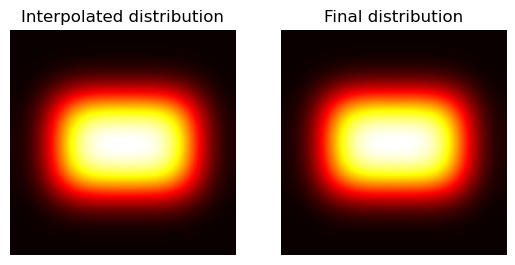

In [33]:
# ============================================================================
# test interpolating function
# ============================================================================
grid=geo_ftcs.get_domain()
inter=cs(grid[:,0],grid[:,1], grid=False)
inter=inter.reshape((geo_ftcs.Nx,geo_ftcs.Ny))
fig, ax=plt.subplots(1,2,)
ax[0].imshow(inter, 'hot')
ax[0].set_axis_off()
ax[0].set_title('Interpolated distribution')

ax[1].imshow(final_2d, 'hot')
ax[1].set_axis_off()
ax[1].set_title('Final distribution')

In [34]:
# ============================================================================
# Loss Functions for 2D Inverse Problem
# ============================================================================

import tensorflow as tf

@tf.function
def loss_pde(net, x,y ,t ,D):
    """
    Compute the PDE residual loss: L_PDE.
    
    Enforces the heat equation: ∂u/∂t = D * ∇²u
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x : array of x internal points
        tensorflow.tensor
    y : array of x internal points
        tensorflow.tensor        
    t : array of time internal points
    tensorflow.tensor
    D : Diffusion coefficient
        tensorflow.tensor
        
    Returns:
    --------
    loss : Mean squared PDE residual
            tensorflow.tensor
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x,y,t]) 
        u=net(tf.stack([x,y,t],-1), training=True)
        u_x, u_y, u_t=tape.gradient(u,[x,y,t]) #calculation of the gradient
    #here we are outside the computational graph

    u_xx=tape.gradient(u_x,x)#second derivative with respect to x
    u_yy=tape.gradient(u_y,y)#second derivative with respect to y
    pde_loss=tf.reduce_mean(tf.square(u_t-D*(u_xx+u_yy)))
    return pde_loss

@tf.function
def grad_dir(net, points, direction):
    with tf.GradientTape() as tape:
        tape.watch(points)
        u=net(points, training=True)
    grad_u=tape.gradient(u,points)
    if direction=='x':
        return grad_u[:,0]
    else:
        return grad_u[:,1]

def loss_bc(net,points_left, points_right, points_down, points_up):
    """
    Compute the boundary condition loss: L_BC.
    
    Enforces Dirichlet BC:n · ∇u=0
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    points_left : array of spatial points, where x = 0 
        tf.tensor
    points_right : array of spatial points, where x = Lx 
        tf.tensor        
    points_down : array of spatial points, where y = 0 
        tf.tensor        
    points_up : array of spatial points, where y = Ly 
        tf.tensor                
    Returns:
    --------
    loss : float
        Mean squared boundary predictions (should be zero)
    """    
    
    u_left=grad_dir(net,points_left,'x')
    u_right=grad_dir(net,points_right,'x')
    u_down=grad_dir(net, points_down, 'y')
    u_up=grad_dir(net, points_up, 'y')

    
    BC_loss=tf.reduce_mean([tf.square(u_left),tf.square(u_right),tf.square(u_down), tf.square(u_up)]) 
    return BC_loss



@tf.function
def loss_data(net,x_data,y_data,t_data,true_data):
    """
    Compute the data driven loss.
    
    Parameters:
    -----------
    net : Pinn model
        keras model
    x_data : array of spatial points
    y_data : array of spatial points
    t_data : array of time points, with t = 1.0
    true_data : Interpolated point values: A(x_data,y_data, t_data)
        
    Returns:
    --------
    loss : float
        Mean squared error between predictions and intepolated data
    """    
    uic=net(tf.stack([x_data,y_data,t_data],-1),training=True)
    IC_loss=tf.reduce_mean(tf.square(uic-true_data))
    return IC_loss



def PDE_inverse_2D(network, point_int, point_BC, point_data, D,cs):
    """
    Compute the total physics-informed loss.
    
    L_total = L_PDE + L_BC + L_data
    
    Parameters:
    -----------
    network : Pinn model
        keras model
    points_int : array
        Interior domain points
    points_BC : dict, keys=[left, right, down, up]
        Boundary points
    points_dat : array
        Experimental condition points
    D : float
        Diffusion coefficient
    cs : interpolating function
    
        
    Returns:
    --------
    total : float
        Total loss value
    components : tuple
        Individual loss components (l_pde, l_bc, l_ic) for monitoring
    """


    
    #Since we are running loss computation under @tf.funtion its better working only with tensors
    x=tf.constant(point_int[:,0], tf.float32)
    y=tf.constant(point_int[:,1], tf.float32)
    t=tf.constant(point_int[:,2], tf.float32)
    D=tf.constant(D, tf.float32)
    pde_loss=loss_pde(network,x,y,t,D)


    point_left=tf.constant(point_BC['left'], tf.float32)
    point_right=tf.constant(point_BC['right'], tf.float32)
    point_down=tf.constant(point_BC['down'], tf.float32)
    point_up=tf.constant(point_BC['up'], tf.float32)
    BC_loss=loss_bc(network,point_left, point_right, point_down, point_up)

    xic=tf.constant(point_data[:,0], tf.float32)
    yic=tf.constant(point_data[:,1], tf.float32)
    tic=tf.constant(point_data[:,2], tf.float32)
    true_ic=tf.cast(np.expand_dims(cs(xic,yic, grid=False),-1),tf.float32)
    IC_loss=loss_data(network,xic, yic,tic,true_ic)

    total_loss=pde_loss+BC_loss+IC_loss
    return total_loss,pde_loss,BC_loss, IC_loss

In [35]:
point_int=geo2.sample_interior(10)
point_BC=geo2.sample_boundary(20)
point_IC=geo2.sample_at_time(10, t_measure_2d)

#t_loss, (l_pde, l_bc, l_data) = PDE(pinn2d,point_int,point_BC,point_IC,0.249,cs)
a=PDE_inverse_2D(pinn2d,point_int,point_BC,point_IC,0.249,cs)
a

(<tf.Tensor: shape=(), dtype=float32, numpy=0.08197214>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.007914694>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.002405075>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07165237>)

## 10.6 Training the 2D Inverse PINN

Now we set up the data interpolator and train the PINN to solve the inverse problem.

In [36]:
# ============================================================================
# Step 4: Modify the training loop for the 2D inverse problem
# ============================================================================

def train_pinn_inverse_2d(pinn2d, geo, D, n_epochs=5000, N1=1000, N2=200, N4=200, learning_rate=1e-3, checkpoint_dir = None, summary_function=None, fine_tune : bool = False, t_m = None ,cs=None):
    """
    Train the Physics-Informed Neural Network.
    
    Parameters:
    -----------
    pinn2d : Pinn
        PINN object to train
    geo : Geometry
        Geometry object for sampling points
    D : float
        Diffusion coefficient
    n_epochs : int
        Number of training iterations
    N1, N2, N4 : int
        Number of interior, boundary, and initial condition points per epoch
    learning_rate : float
        Adam optimizer learning rate
    checkpoint_dir : str
        Directory to save model checkpoints (optional). If None, checkpoints are savede in the folder './training_PINN'.
    summary_function : function
        Function to log training summaries (optional)
    fine_tune : bool
        If True, continue training from existing weights
    t_m : float
        Time of measurement
    cs : 2D interpolating function
        Cubic spline interpolation of measurement data
        
    Returns:
    --------
    trained_pinn : Pinn
        Trained PINN model (at the last epoch)
    loss_history : list
        Total loss at each epoch
    loss_components : dict
        History of individual loss components
    """
    # Loss history for monitoring
    loss_history = []
    loss_components = {'pde': [], 'bc': [], 'data': []}

    # Initialize Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if fine_tune:
        print("Computing initial loss before fine-tuning...")
        initial_loss= PDE_inverse_2D(pinn2d,
                  geo.sample_interior(N1),
                  geo.sample_boundary(N2),
                  geo.sample_at_time(N4, t_m),
                  D,cs)
        best_loss= initial_loss[0].numpy()
        loss_history.append(best_loss)
        print(f"Initial total loss: {best_loss:.6f}")
        loss_components['pde'].append(initial_loss[1].numpy())
        loss_components['bc'].append(initial_loss[2].numpy())
        loss_components['data'].append(initial_loss[3].numpy())
    else:
        best_loss = np.inf

    print(f"Starting training for {n_epochs} epochs...")
    print(f"Sampling: N1={N1} (interior), N2={N2} (boundary), N4={N4} (initial)\n")
    
    # Setup checkpointing
    print('Setting up checkpointing...')
    if checkpoint_dir is None:
        checkpoint_dir = './training_PINN_inverse_2D'
    print(f'Checkpoint directory: {checkpoint_dir}')
    checkpoint=tf.train.Checkpoint(
                generator_optimizer=optimizer,
                generator=pinn
                    )
    manager=tf.train.CheckpointManager(checkpoint,checkpoint_dir, max_to_keep=1)

    
    for epoch in range(n_epochs):
        # Sample points
        points_interior = geo.sample_interior(N1)
        points_boundary = geo.sample_boundary(N2)
        points_data = geo.sample_at_time(N4, t_m)

        with tf.GradientTape() as tape:
            total_loss, pde_loss, bc_loss, data_loss = PDE_inverse_2D(
                pinn2d, points_interior, points_boundary, points_data, D,cs)
        # Record losses
        loss_history.append(total_loss.numpy())
        loss_components['pde'].append(pde_loss.numpy())
        loss_components['bc'].append(bc_loss.numpy())
        loss_components['data'].append(data_loss.numpy())
        
        # Compute gradients and update weights
        gradients = tape.gradient(total_loss, pinn2d.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn2d.trainable_variables))

        if total_loss<best_loss:
            #print('Find new best! Model checkpoint saving')
            manager.save()

        # Log summaries if function provided
        if summary_function:
            summary_function(epoch, total_loss, pde_loss, bc_loss, data_loss)

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{n_epochs} - Total Loss: {total_loss:.6f} "
                    f"(PDE: {pde_loss:.6f}, BC: {bc_loss:.6f}, DATA: {data_loss:.6f})")
    
    print("Training completed!")
    return pinn2d, loss_history, loss_components

In [37]:
#define a summary function

#A nice way to log the losses during training is to use tensorboard
# define folders for tensorboard logs
log_dir="logs_2d_inverse/"
summary_writer = tf.summary.create_file_writer(
log_dir + "total_loss/")
summary_writer_2 = tf.summary.create_file_writer(
log_dir + 'pde_loss/')
summary_writer_3 = tf.summary.create_file_writer(
log_dir + 'ic_loss/')
summary_writer_4 = tf.summary.create_file_writer(
log_dir + 'bc_loss/')

def summary_function_inverse2D(epoch, total_loss, pde_loss, bc_loss, ic_loss):
    with summary_writer.as_default():
        tf.summary.scalar('total_loss', total_loss, step=epoch+1)
    with summary_writer_2.as_default():
        tf.summary.scalar('pde_loss', pde_loss, step=epoch+1)
    with summary_writer_3.as_default():
        tf.summary.scalar('ic_loss', ic_loss, step=epoch+1)
    with summary_writer_4.as_default():
        tf.summary.scalar('bc_loss', bc_loss, step=epoch+1)

#first kill any existing tensorboard instances
!kill $(lsof -t -i:6006) 2>/dev/null || echo "No existing tensorboard instances."

%load_ext tensorboard  

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
#this command launches tensorboard platform
#here we will see the losses during training
#if it doesn't appear try run twice
#set on time series
#set Reload data
%tensorboard --logdir=$log_dir

In [39]:
history=train_pinn_inverse_2d(pinn2d,geo2,D_2d,1000,20000,20000,40000,cs=cs,t_m=t_measure_2d, summary_function=summary_function_inverse2D)

Starting training for 1000 epochs...
Sampling: N1=20000 (interior), N2=20000 (boundary), N4=40000 (initial)

Setting up checkpointing...
Checkpoint directory: ./training_PINN_inverse_2D
Epoch 1/1000 - Total Loss: 0.123317 (PDE: 0.007738, BC: 0.002982, DATA: 0.112596)
Epoch 100/1000 - Total Loss: 0.088792 (PDE: 0.000011, BC: 0.000480, DATA: 0.088301)
Epoch 200/1000 - Total Loss: 0.088234 (PDE: 0.000013, BC: 0.000722, DATA: 0.087500)
Epoch 300/1000 - Total Loss: 0.087907 (PDE: 0.000017, BC: 0.000834, DATA: 0.087056)
Epoch 400/1000 - Total Loss: 0.088817 (PDE: 0.000015, BC: 0.000851, DATA: 0.087950)
Epoch 500/1000 - Total Loss: 0.088174 (PDE: 0.000068, BC: 0.001054, DATA: 0.087051)
Epoch 600/1000 - Total Loss: 0.074989 (PDE: 0.000671, BC: 0.001428, DATA: 0.072890)
Epoch 700/1000 - Total Loss: 0.067986 (PDE: 0.000274, BC: 0.001490, DATA: 0.066223)
Epoch 800/1000 - Total Loss: 0.021364 (PDE: 0.001837, BC: 0.002822, DATA: 0.016705)
Epoch 900/1000 - Total Loss: 0.005699 (PDE: 0.000995, BC: 0.

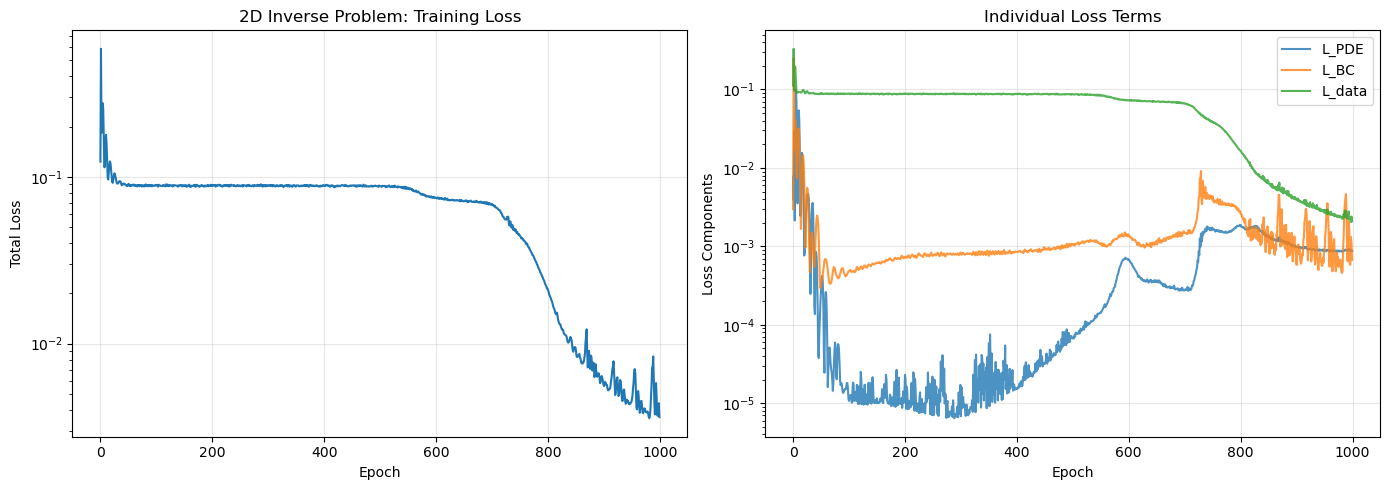

In [40]:
# ============================================================================
# Visualize Training History
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pinn_2d, loss_history_2d, loss_components_2d= history

# Total loss
axes[0].plot(loss_history_2d, linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('2D Inverse Problem: Training Loss')
axes[0].grid(True, alpha=0.3)

# Loss components
axes[1].plot(loss_components_2d['pde'], label='L_PDE', linewidth=1.5, alpha=0.8)
axes[1].plot(loss_components_2d['bc'], label='L_BC', linewidth=1.5, alpha=0.8)
axes[1].plot(loss_components_2d['data'], label='L_data', linewidth=1.5, alpha=0.8)
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Components')
axes[1].set_title('Individual Loss Terms')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10.7 Reconstruction Results

Now we evaluate the PINN's ability to reconstruct the initial dose distribution.

In [41]:
# ============================================================================
# Reconstruct Initial Condition
# ============================================================================
print("\n" + "="*70)
print("RECONSTRUCTING INITIAL CONDITION")
print("="*70)

# Create evaluation grid at t=0
Nx_eval = 100
Ny_eval = 100
x_eval = np.linspace(0, Lx, Nx_eval)
y_eval = np.linspace(0, Ly, Ny_eval)
grid=geo_ftcs.get_domain()
x_flat=grid[:,0]
y_flat=grid[:,1]
t_flat = np.zeros_like(x_flat)  # t = 0 for initial condition
points_t0 = np.column_stack((x_flat, y_flat, t_flat))

# Predict initial condition
print("Evaluating PINN at t=0...")
u_reconstructed = pinn_2d(points_t0).numpy().reshape(Nx_eval, Ny_eval)

# Also evaluate at measurement time for comparison
t_meas_flat = np.full_like(x_flat, t_measure_2d)
points_tmeas = np.column_stack((x_flat, y_flat, t_meas_flat))
u_at_measurement = pinn_2d(points_tmeas).numpy().reshape(Nx_eval, Ny_eval)

print("✓ Reconstruction complete")

# Compute errors
# Interpolate true initial condition to evaluation grid
from scipy.interpolate import RectBivariateSpline
ini_interp = RectBivariateSpline(
    np.linspace(0, Ly, ini_2d.shape[0]),
    np.linspace(0, Lx, ini_2d.shape[1]),
    ini_2d
)
u_true_initial_eval = np.array(ini_interp(y_eval, x_eval))

# Compute metrics
mae_recon = np.mean(np.abs(u_reconstructed - u_true_initial_eval))
mse_recon = np.mean((u_reconstructed - u_true_initial_eval) ** 2)
max_error_recon = np.max(np.abs(u_reconstructed - u_true_initial_eval))

print(f"\nReconstruction Metrics:")
print(f"  Mean Absolute Error: {mae_recon:.6f}")
print(f"  Mean Squared Error:  {mse_recon:.6f}")
print(f"  Maximum Error:       {max_error_recon:.6f}")
print(f"  Relative MAE:        {mae_recon / np.mean(u_true_initial_eval):.2%}")
print("="*70)


RECONSTRUCTING INITIAL CONDITION
Evaluating PINN at t=0...
✓ Reconstruction complete

Reconstruction Metrics:
  Mean Absolute Error: 0.070343
  Mean Squared Error:  0.008900
  Maximum Error:       0.323078
  Relative MAE:        30.57%


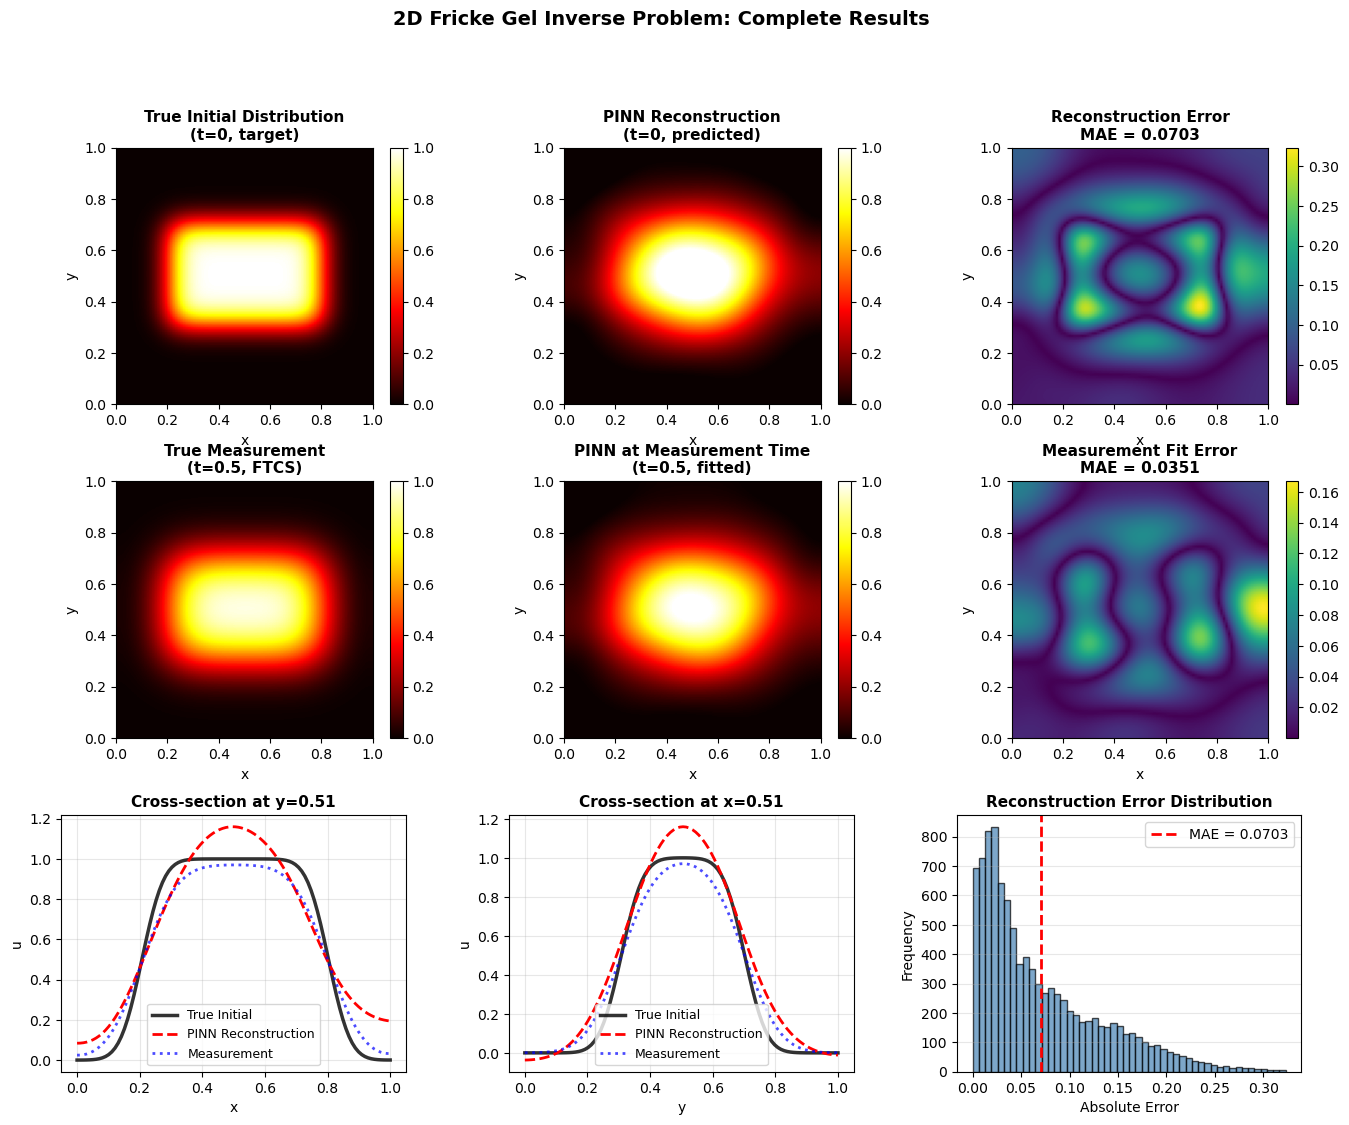

In [42]:
# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Initial condition (true, reconstructed, error)
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(u_true_initial_eval, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('True Initial Distribution\n(t=0, target)', fontsize=11, fontweight='bold')
plt.colorbar(im1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(u_reconstructed, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('PINN Reconstruction\n(t=0, predicted)', fontsize=11, fontweight='bold')
plt.colorbar(im2, ax=ax2, fraction=0.046)

ax3 = fig.add_subplot(gs[0, 2])
error_initial = np.abs(u_reconstructed - u_true_initial_eval)
im3 = ax3.imshow(error_initial, cmap='viridis', origin='lower', extent=[0, Lx, 0, Ly])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(f'Reconstruction Error\nMAE = {mae_recon:.4f}', fontsize=11, fontweight='bold')
plt.colorbar(im3, ax=ax3, fraction=0.046)

# Row 2: Measurement time comparison
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(final_2d, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title(f'True Measurement\n(t={t_measure_2d}, FTCS)', fontsize=11, fontweight='bold')
plt.colorbar(im4, ax=ax4, fraction=0.046)

ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(u_at_measurement, cmap='hot', origin='lower', 
                 extent=[0, Lx, 0, Ly], vmin=0, vmax=1)
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_title(f'PINN at Measurement Time\n(t={t_measure_2d}, fitted)', fontsize=11, fontweight='bold')
plt.colorbar(im5, ax=ax5, fraction=0.046)

ax6 = fig.add_subplot(gs[1, 2])
# Interpolate final_2d to evaluation grid for comparison
final_interp = RectBivariateSpline(
    np.linspace(0, Ly, final_2d.shape[0]),
    np.linspace(0, Lx, final_2d.shape[1]),
    final_2d
)
final_2d_eval = np.array(final_interp(y_eval, x_eval))
error_measurement = np.abs(u_at_measurement - final_2d_eval)
im6 = ax6.imshow(error_measurement, cmap='viridis', origin='lower', extent=[0, Lx, 0, Ly])
ax6.set_xlabel('x')
ax6.set_ylabel('y')
mae_meas = np.mean(error_measurement)
ax6.set_title(f'Measurement Fit Error\nMAE = {mae_meas:.4f}', fontsize=11, fontweight='bold')
plt.colorbar(im6, ax=ax6, fraction=0.046)

# Row 3: Cross-sections and diffusion visualization
ax7 = fig.add_subplot(gs[2, 0])
mid_y_idx = Ny_eval // 2
ax7.plot(x_eval, u_true_initial_eval[mid_y_idx, :], 'k-', 
         label='True Initial', linewidth=2.5, alpha=0.8)
ax7.plot(x_eval, u_reconstructed[mid_y_idx, :], 'r--', 
         label='PINN Reconstruction', linewidth=2)
ax7.plot(x_eval, final_2d_eval[mid_y_idx, :], 'b:', 
         label='Measurement', linewidth=2, alpha=0.7)
ax7.set_xlabel('x')
ax7.set_ylabel('u')
ax7.set_title(f'Cross-section at y={y_eval[mid_y_idx]:.2f}', fontsize=11, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
mid_x_idx = Nx_eval // 2
ax8.plot(y_eval, u_true_initial_eval[:, mid_x_idx], 'k-', 
         label='True Initial', linewidth=2.5, alpha=0.8)
ax8.plot(y_eval, u_reconstructed[:, mid_x_idx], 'r--', 
         label='PINN Reconstruction', linewidth=2)
ax8.plot(y_eval, final_2d_eval[:, mid_x_idx], 'b:', 
         label='Measurement', linewidth=2, alpha=0.7)
ax8.set_xlabel('y')
ax8.set_ylabel('u')
ax8.set_title(f'Cross-section at x={x_eval[mid_x_idx]:.2f}', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# Error histogram
ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(error_initial.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax9.axvline(mae_recon, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae_recon:.4f}')
ax9.set_xlabel('Absolute Error')
ax9.set_ylabel('Frequency')
ax9.set_title('Reconstruction Error Distribution', fontsize=11, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.suptitle('2D Fricke Gel Inverse Problem: Complete Results', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

## 10.8 Key Observations and Extensions

### 🎯 What We Accomplished

1. **Solved a realistic 2D inverse problem** - Reconstructed initial dose distribution from diffused measurements
2. **Used existing simulation tools** - Leveraged FTCS module for ground truth data generation
3. **Implemented JAX-based PINN** - Custom architecture consistent with the notebook's approach
4. **Enforced physical constraints** - PDE and Neumann boundary conditions built into the loss

### 🔬 Physical Insights

- **Diffusion blurs information**: The longer the time between irradiation and measurement, the harder reconstruction becomes
- **Inverse problems are ill-posed**: Small changes in measurements can lead to large changes in reconstructed initial conditions
- **Boundary conditions matter**: Neumann (no-flux) BCs are physically appropriate for sealed gel containers

### 🚀 Suggested Extensions

1. **Time sensitivity analysis**: 
   - Try different `t_measure_2d` values (0.1, 0.3, 0.5, 1.0)
   - Plot reconstruction error vs. measurement time
   - Find the "practical limit" for reconstruction

2. **Noise robustness**:
   ```python
   # Add noise to measurements
   noise_level = 0.05
   final_2d_noisy = final_2d + noise_level * np.random.randn(*final_2d.shape)
   ```
   - How does measurement noise affect reconstruction quality?
   - Can regularization improve robustness?

3. **Unknown diffusion coefficient**:
   - Make `D` a learnable parameter
   - Simultaneously learn both initial condition and `D`
   - This is a "double inverse" problem!

4. **Sparse measurements**:
   - Instead of full 2D measurement, use only scattered point measurements
   - More realistic for actual experimental setups
   - Tests PINN's interpolation capabilities

5. **Different initial geometries**:
   - Try circle, multiple spots, or arbitrary shapes
   - Test on clinically relevant dose distributions
   - Vary smoothness and complexity

6. **Comparison with other methods**:
   - Backward FTCS (unstable but instructive)
   - Tikhonov regularization
   - Traditional deconvolution techniques

### 💡 Tips for Better Results

- **Loss weighting**: Experiment with `w_pde`, `w_bc`, `w_data` ratios
- **Network capacity**: Increase layers/neurons for complex distributions
- **Training duration**: 2D problems may need 10,000+ epochs
- **Learning rate schedule**: Consider decay strategies
- **Multiple initializations**: Run with different random seeds and ensemble results

---

## 🎓 Conclusion

This advanced exercise demonstrates PINNs' power for solving **realistic inverse problems** in medical physics. By combining:
- Physical laws (diffusion equation)
- Boundary constraints (Neumann conditions)  
- Sparse/indirect measurements (diffused dose)

We can recover information that would be impossible with data-driven methods alone. This approach is directly applicable to:
- **Radiation therapy dosimetry** (Fricke gels)
- **Drug delivery** (diffusion in tissues)
- **Environmental monitoring** (pollutant dispersion)
- **Materials science** (thermal/mass transport)

The key insight: **Physics-informed learning bridges the gap between incomplete data and underlying physical reality.**